# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "./data/network-traffic-volume-2019-07-01.csv"

history = 24  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 50  # maximal trials for hyper parameter tuning

model_name = 'ResNet'
# Save the results
y_true_fn = '%s_true-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred-%d-%d.pkl' % (model_name, history, horizon)

In [10]:
y_true_fn

'ResNet_true-24-1.pkl'

In [11]:
y_pred_fn

'ResNet_pred-24-1.pkl'

# Load Data

In [12]:
df = pd.read_csv(file_name, sep=';')

In [13]:
start = datetime(1970, 1, 1)  # Unix epoch start time
df['datetime'] = df.clock.apply(lambda x: start + timedelta(seconds=x))

In [14]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
0,159138,1563192000,60,170651112,222446310,245355432,2019-07-15 12:00:00
1,159138,1563188400,60,92258968,156333926,245517360,2019-07-15 11:00:00
2,159138,1563184800,60,29854256,73581269,121096792,2019-07-15 10:00:00
3,159138,1563181200,60,333720,12801917,43525128,2019-07-15 09:00:00
4,159138,1563177600,60,183976,1146488,11797152,2019-07-15 08:00:00


Reverse the data order:

In [15]:
df = df.reindex(index=df.index[::-1])
df = df.reset_index(drop=True)

In [16]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
0,159138,1547647200,60,176234272,218584709,282860160,2019-01-16 14:00:00
1,159138,1547650800,60,175043128,239018429,302135312,2019-01-16 15:00:00
2,159138,1547654400,60,192060848,247729961,455722696,2019-01-16 16:00:00
3,159138,1547658000,60,185162976,222326142,268226440,2019-01-16 17:00:00
4,159138,1547661600,60,169504880,220546435,306695032,2019-01-16 18:00:00


In [17]:
# add a datetimeindex
dates = pd.DatetimeIndex(df['datetime'])
df = df.set_index(dates).asfreq('H')  # one hour as the original sampling time frequency

In [18]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
datetime,,,,,,,
2019-01-16 14:00:00,159138,1547647200,60,176234272,218584709,282860160,2019-01-16 14:00:00
2019-01-16 15:00:00,159138,1547650800,60,175043128,239018429,302135312,2019-01-16 15:00:00
2019-01-16 16:00:00,159138,1547654400,60,192060848,247729961,455722696,2019-01-16 16:00:00
2019-01-16 17:00:00,159138,1547658000,60,185162976,222326142,268226440,2019-01-16 17:00:00
2019-01-16 18:00:00,159138,1547661600,60,169504880,220546435,306695032,2019-01-16 18:00:00


# Split the data

In [19]:
train = df[df['datetime'] < '2019-06-16 00:00:00']
test = df[df['datetime'] > '2019-06-16 00:00:00']
train_length = train.shape[0]
test_length = test.shape[0]

In [20]:
print('Training size: ', train_length)
print('Test size: ', test_length)

Training size:  3610
Test size:  708


In [21]:
print('Test ratio: ', test_length / (test_length + train_length))

Test ratio:  0.16396479851783233


We plot the different time periods data:

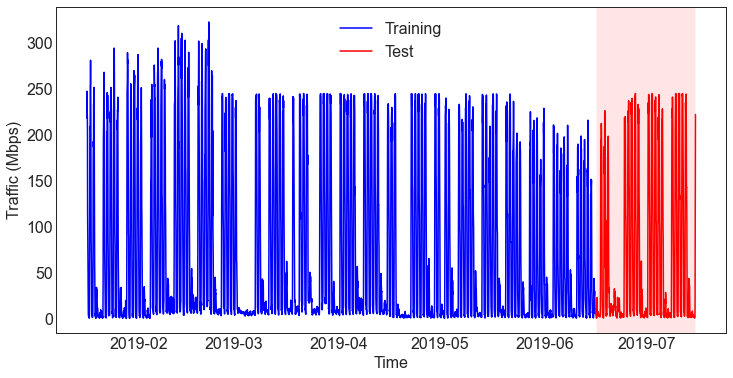

In [22]:
plt.figure(figsize=[12, 6])
plt.plot(df.index[:train_length], df['value_avg'][:train_length] / 1000 / 1000, label='Training', color='blue')
plt.plot(df.index[train_length:], df['value_avg'][train_length:] / 1000 / 1000, label='Test', color='red')
plt.axvspan(df.index[train_length:][0], df.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

# Normalize the data

Define the input features and the target column:

In [23]:
input_features = ['value_avg', 'value_min', 'value_max']

In [24]:
data = df[input_features].values

Calculate the min and max data based on the training data set:

In [25]:
max_list = np.max(data[:train_length], axis=0)

In [26]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [27]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [28]:
print(np.max(data[:train_length].flatten()))

1.0


In [29]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [30]:
print(np.max(data.flatten()))

1.0


In [31]:
print(np.min(data.flatten()))

0.0


# Build the supervised prediction problem

The input data is in the following format:

* x_data as input features: [data size, input channels, input historical steps]. Here the input channel number is the input feature numbers. For univariate time series case, the input channel is 1 (value_avg). For multivariate time series case, the input channel is 3 (value_avg, value_max, value_min).
* y_data as output targets: [data size, output prediction steps].

In [32]:
length = data.shape[0]
print(length)

4319


In [33]:
x_data = []
y_data = []
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, 0]  # output predicted time steps, we only predict value_avg
    x_data.append(x)
    y_data.append(y)

In [34]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [35]:
x_data.shape

(4295, 24, 3)

In [36]:
y_data.shape

(4295, 1)

Reshape x_data:

In [37]:
x_data = np.swapaxes(x_data, 1, 2)

In [38]:
x_data.shape

(4295, 3, 24)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [39]:
test_length = test_length - horizon + 1

In [40]:
train_valid_length = x_data.shape[0] - test_length

In [41]:
train_valid_length

3587

We further split a valid data set for hyper parameter tuning:

In [42]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [43]:
train_length

2869

In [44]:
valid_length

718

In [45]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [46]:
X_train.shape

(2869, 3, 24)

In [47]:
y_train.shape

(2869, 1)

In [48]:
X_valid.shape

(718, 3, 24)

In [49]:
y_valid.shape

(718, 1)

In [50]:
X_test.shape

(708, 3, 24)

In [51]:
y_test.shape

(708, 1)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [52]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [53]:
splits

((#2869) [0,1,2,3,4,5,6,7,8,9...],
 (#718) [2869,2870,2871,2872,2873,2874,2875,2876,2877,2878...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [54]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [55]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
}

In [56]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x23df8312cc8>,
 'lr': <hyperopt.pyll.base.Apply at 0x23df83191c8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x23df83196c8>,
 'patience': <hyperopt.pyll.base.Apply at 0x23df8319b48>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x23df8319f08>}

In [57]:
# clear memory 
gc.collect()

2986

In [58]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = ResNet
        model = create_model(arch, dls=dls)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except Exception as e:
        print(e)
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
  0%|                                                                           | 0/50 [00:01<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.008187,0.007636,0.061624,0.087384,00:04
1,0.005718,0.005294,0.043366,0.072757,00:02
2,0.003847,0.007421,0.052738,0.086143,00:02
3,0.006184,0.005311,0.046785,0.072878,00:02
4,0.003807,0.004533,0.046085,0.067325,00:02
5,0.002810,0.004698,0.040821,0.068545,00:02
6,0.002110,0.003316,0.035005,0.057587,00:02
7,0.001880,0.004330,0.039199,0.065803,00:02
8,0.001807,0.004366,0.039463,0.066077,00:02
9,0.002310,0.002449,0.032220,0.049489,00:02


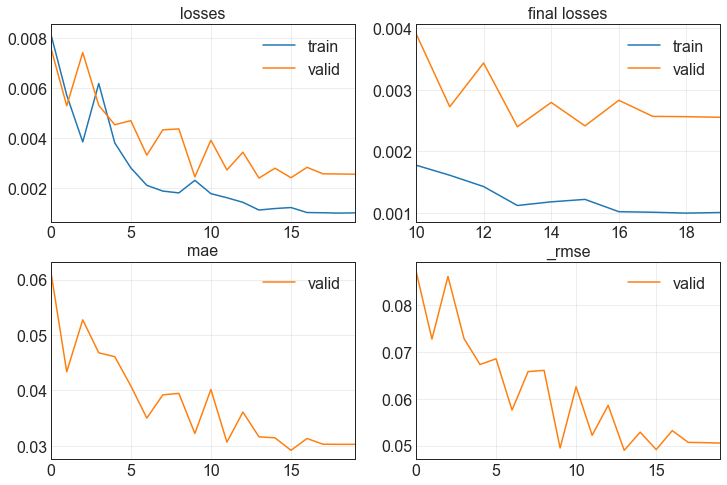

56.0054030418396                                                                                                       
[0.00100854376796633, 0.0025544650852680206, 0.030268384143710136, 0.0505417175590992]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
  2%|▉                                             | 1/50 [00:58<47:21, 58.00s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.006934,0.009470,0.063758,0.097313,00:02
1,0.003855,0.008198,0.059685,0.090542,00:02
2,0.002793,0.004020,0.048004,0.063401,00:02
3,0.003129,0.006480,0.054541,0.080500,00:02
4,0.002740,0.008948,0.059596,0.094596,00:02
5,0.002394,0.005073,0.043547,0.071227,00:02
6,0.002080,0.003694,0.038241,0.060782,00:02
7,0.002033,0.004622,0.042237,0.067984,00:02
8,0.002561,0.005058,0.042936,0.071119,00:02
9,0.001888,0.003405,0.040172,0.058355,00:02


No improvement since epoch 9: early stopping                                                                           
  2%|▉                                             | 1/50 [01:52<47:21, 58.00s/trial, best loss: 0.0025544650852680206]

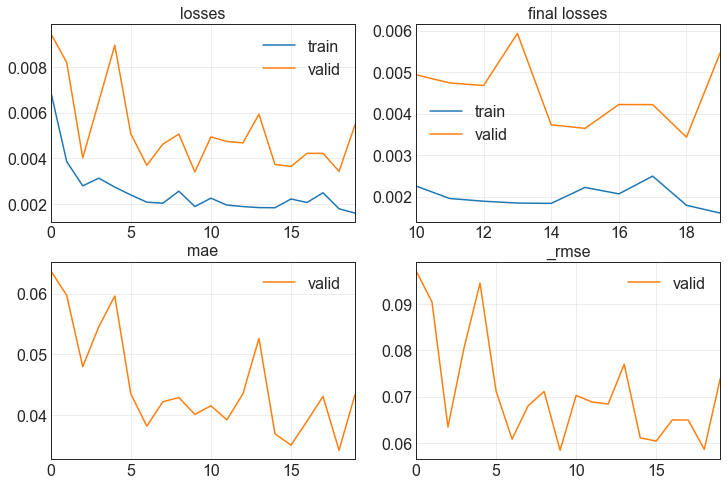

54.05340266227722                                                                                                      
[0.001599710900336504, 0.005470675881952047, 0.04345382750034332, 0.07396401464939117]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
  4%|█▊                                            | 2/50 [01:53<45:34, 56.97s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.026357,0.047296,0.161874,0.217477,00:00
1,0.013276,0.009359,0.059215,0.096742,00:00
2,0.008385,0.005044,0.044013,0.071022,00:00
3,0.005979,0.004880,0.043381,0.069854,00:00
4,0.004438,0.008544,0.060528,0.092433,00:00
5,0.003939,0.005184,0.045746,0.072002,00:00
6,0.003285,0.008328,0.057828,0.091258,00:00
7,0.002925,0.006701,0.053219,0.081857,00:00
8,0.002518,0.004992,0.040747,0.070654,00:00
9,0.002346,0.006743,0.051713,0.082117,00:00


No improvement since epoch 27: early stopping                                                                          
  4%|█▊                                            | 2/50 [02:07<45:34, 56.97s/trial, best loss: 0.0025544650852680206]

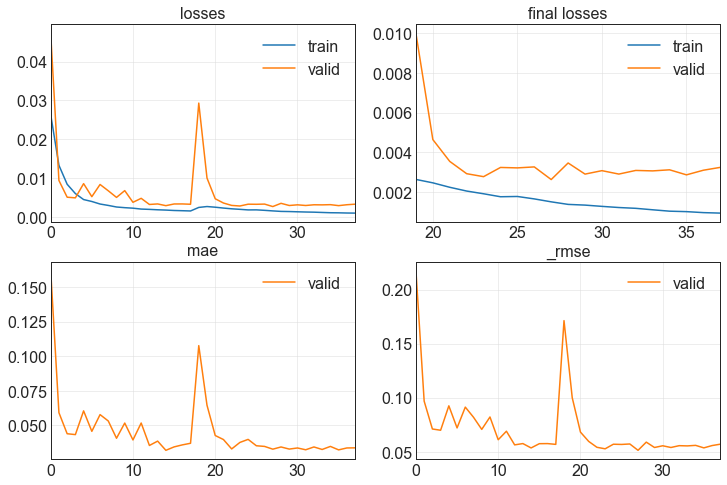

14.591675758361816                                                                                                     
[0.00094292574794963, 0.003245079657062888, 0.03381075710058212, 0.05696559697389603]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}     
ResNet                                                                                                                 
  6%|██▊                                           | 3/50 [02:08<34:47, 44.42s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.084644,0.112038,0.304155,0.334721,00:00
1,0.055115,0.053194,0.205197,0.230638,00:00
2,0.037498,0.035927,0.169306,0.189543,00:00
3,0.025918,0.019526,0.119834,0.139737,00:00
4,0.018147,0.011455,0.086944,0.107027,00:00
5,0.012883,0.006514,0.062810,0.080712,00:00
6,0.009461,0.004963,0.050830,0.070450,00:00
7,0.007059,0.006756,0.060560,0.082195,00:00
8,0.005395,0.004948,0.052575,0.070342,00:00
9,0.004144,0.004610,0.049132,0.067898,00:00


No improvement since epoch 15: early stopping                                                                          
  6%|██▊                                           | 3/50 [02:15<34:47, 44.42s/trial, best loss: 0.0025544650852680206]

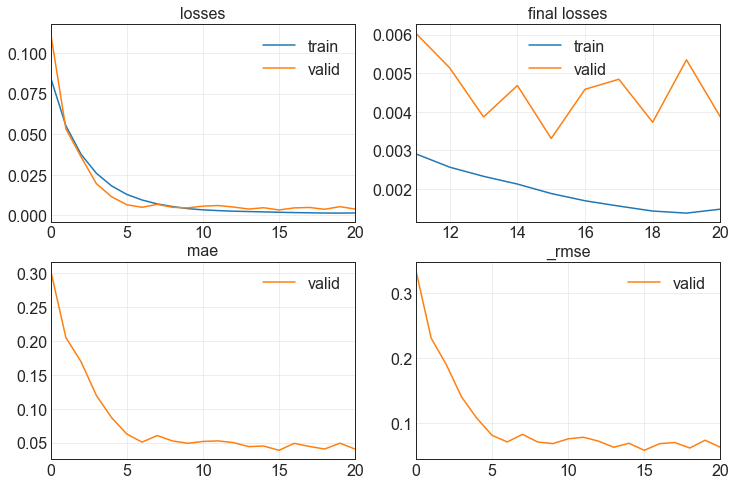

8.1787428855896                                                                                                        
[0.0014779312768951058, 0.003871355904266238, 0.04060159623622894, 0.062220215797424316]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
  8%|███▋                                          | 4/50 [02:16<25:50, 33.71s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.012655,0.005155,0.055815,0.071798,00:00
1,0.006588,0.009731,0.071922,0.098645,00:00
2,0.004188,0.010317,0.069402,0.101573,00:00
3,0.003227,0.005110,0.041568,0.071486,00:00
4,0.003076,0.006716,0.050306,0.081951,00:00
5,0.002736,0.006213,0.052622,0.078823,00:00
6,0.002568,0.005686,0.045717,0.075408,00:00
7,0.002395,0.004305,0.039934,0.065615,00:00
8,0.002334,0.003236,0.033827,0.056883,00:00
9,0.002289,0.003833,0.040081,0.061912,00:00


No improvement since epoch 8: early stopping                                                                           
  8%|███▋                                          | 4/50 [02:26<25:50, 33.71s/trial, best loss: 0.0025544650852680206]

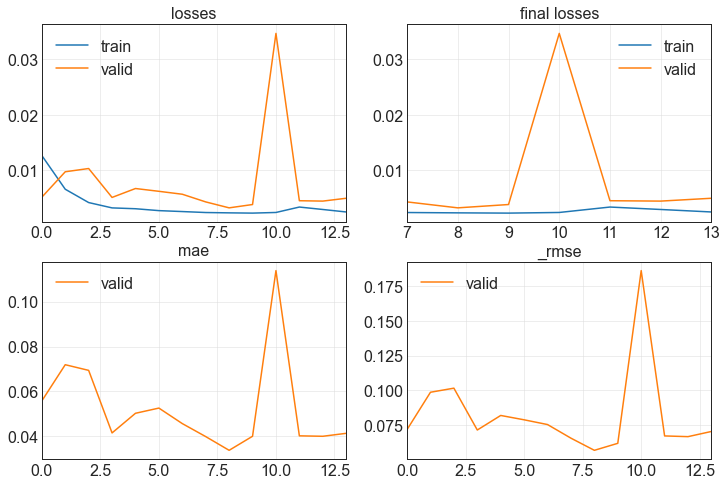

10.208749532699585                                                                                                     
[0.002493375213816762, 0.004962016362696886, 0.041387129575014114, 0.0704415813088417]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 10%|████▌                                         | 5/50 [02:27<20:06, 26.82s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.059425,0.052836,0.207542,0.229860,00:01
1,0.021591,0.019651,0.126023,0.140183,00:01
2,0.010431,0.012380,0.096344,0.111264,00:01
3,0.005695,0.007764,0.069780,0.088114,00:01
4,0.004592,0.009103,0.075957,0.095412,00:01
5,0.003478,0.009229,0.077861,0.096066,00:01
6,0.002875,0.006370,0.057401,0.079814,00:01
7,0.002876,0.005924,0.051521,0.076969,00:01
8,0.002479,0.004383,0.047310,0.066202,00:01
9,0.002438,0.006121,0.058081,0.078238,00:01


No improvement since epoch 14: early stopping                                                                          
 10%|████▌                                         | 5/50 [03:01<20:06, 26.82s/trial, best loss: 0.0025544650852680206]

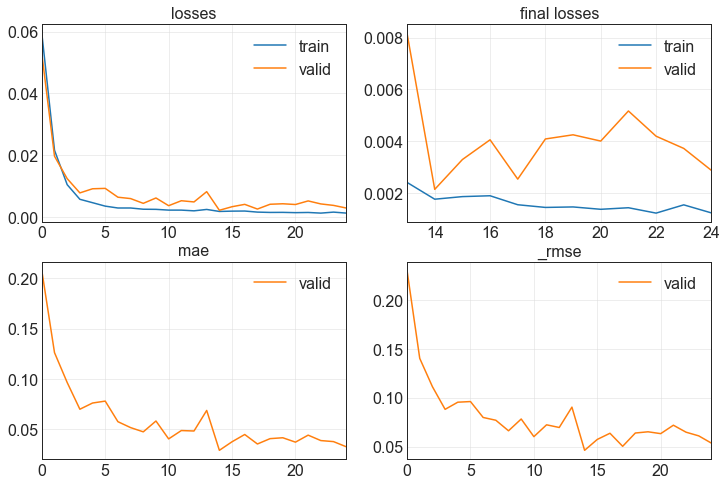

34.30254673957825                                                                                                      
[0.0012283994583413005, 0.0028714437503367662, 0.0325174480676651, 0.053585853427648544]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 12%|█████▌                                        | 6/50 [03:02<21:25, 29.22s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.097167,0.104062,0.294078,0.322587,00:00
1,0.051699,0.025812,0.140111,0.160660,00:00
2,0.029953,0.022209,0.119336,0.149028,00:00
3,0.018516,0.009996,0.082796,0.099978,00:00
4,0.012233,0.009369,0.069895,0.096796,00:00
5,0.008648,0.007374,0.063465,0.085871,00:00
6,0.006266,0.004405,0.047835,0.066372,00:00
7,0.004665,0.005039,0.048930,0.070989,00:00
8,0.003647,0.004020,0.046407,0.063401,00:00
9,0.002876,0.004037,0.044882,0.063540,00:00


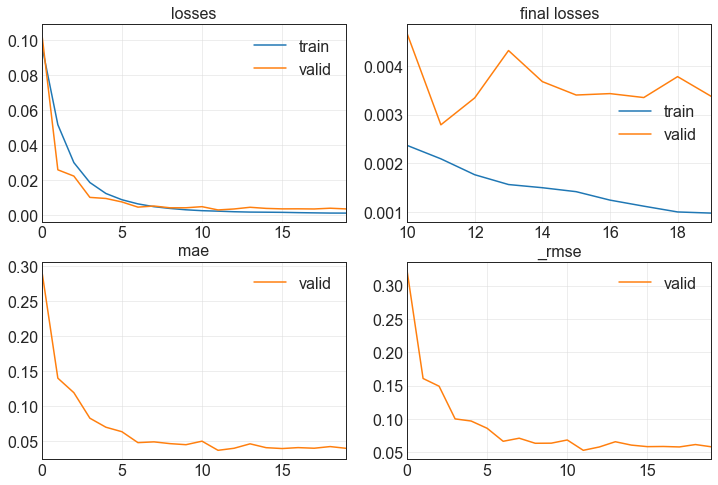

7.791024446487427                                                                                                      
[0.0009754213388077915, 0.003372953040525317, 0.03968525305390358, 0.0580771304666996]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 14%|██████▍                                       | 7/50 [03:10<16:26, 22.95s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.006808,0.004464,0.041374,0.066816,00:02
1,0.003566,0.004966,0.050360,0.070467,00:02
2,0.002559,0.007524,0.052872,0.086740,00:02
3,0.002759,0.004531,0.041191,0.067310,00:02
4,0.002986,0.009091,0.059516,0.095345,00:02
5,0.002482,0.002822,0.032628,0.053122,00:02
6,0.002286,0.003779,0.035720,0.061470,00:02
7,0.002193,0.003793,0.037724,0.061587,00:02
8,0.002029,0.003924,0.040478,0.062642,00:02
9,0.002198,0.005696,0.043964,0.075473,00:02


No improvement since epoch 5: early stopping                                                                           
 14%|██████▍                                       | 7/50 [03:40<16:26, 22.95s/trial, best loss: 0.0025544650852680206]

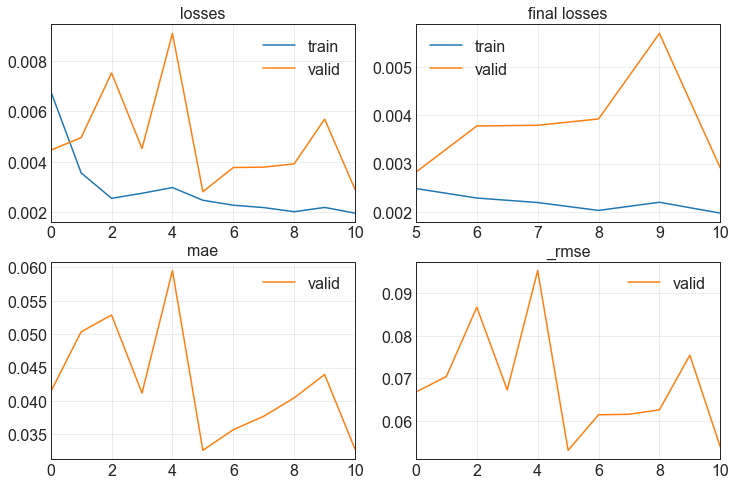

29.775806665420532                                                                                                     
[0.001973462291061878, 0.0029078712686896324, 0.03277978301048279, 0.05392467975616455]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 16%|███████▎                                      | 8/50 [03:41<17:36, 25.16s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.086073,0.068359,0.233426,0.261456,00:00
1,0.035149,0.017039,0.113130,0.130534,00:00
2,0.016106,0.006420,0.063781,0.080122,00:00
3,0.008837,0.017703,0.103912,0.133053,00:00
4,0.005601,0.005999,0.056090,0.077452,00:00
5,0.003778,0.003531,0.042883,0.059419,00:00
6,0.002880,0.009099,0.077696,0.095388,00:00
7,0.002303,0.003909,0.046484,0.062523,00:00
8,0.002254,0.005347,0.053064,0.073121,00:00
9,0.001945,0.003083,0.034379,0.055527,00:00


No improvement since epoch 12: early stopping                                                                          
 16%|███████▎                                      | 8/50 [03:53<17:36, 25.16s/trial, best loss: 0.0025544650852680206]

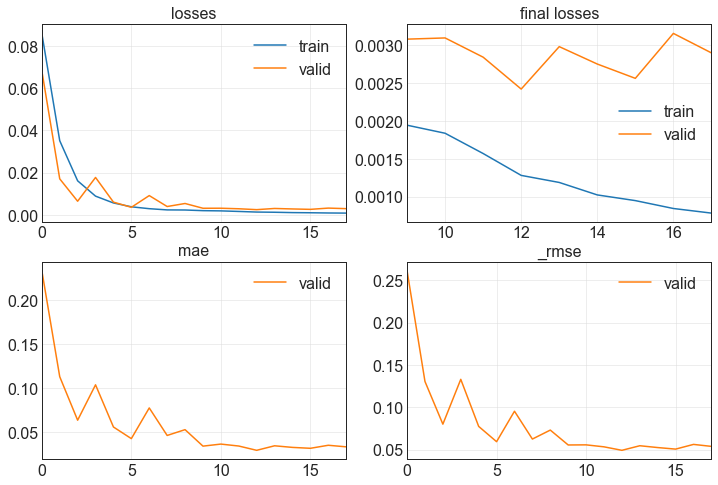

12.881904602050781                                                                                                     
[0.000782456248998642, 0.0029014409519732, 0.0335761196911335, 0.05386502668261528]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}      
ResNet                                                                                                                 
 18%|████████▎                                     | 9/50 [03:54<14:47, 21.64s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.084618,0.069039,0.235962,0.262752,00:00
1,0.043920,0.034541,0.167856,0.185852,00:00
2,0.024480,0.016697,0.114779,0.129217,00:00
3,0.014380,0.008291,0.079398,0.091054,00:00
4,0.008816,0.011837,0.089753,0.108798,00:00
5,0.006055,0.006668,0.063792,0.081659,00:00
6,0.004427,0.005962,0.057706,0.077217,00:00
7,0.003440,0.007221,0.065387,0.084977,00:00
8,0.002906,0.007476,0.061450,0.086465,00:00
9,0.002640,0.005495,0.052025,0.074131,00:00


No improvement since epoch 17: early stopping                                                                          
 18%|████████▎                                     | 9/50 [04:10<14:47, 21.64s/trial, best loss: 0.0025544650852680206]

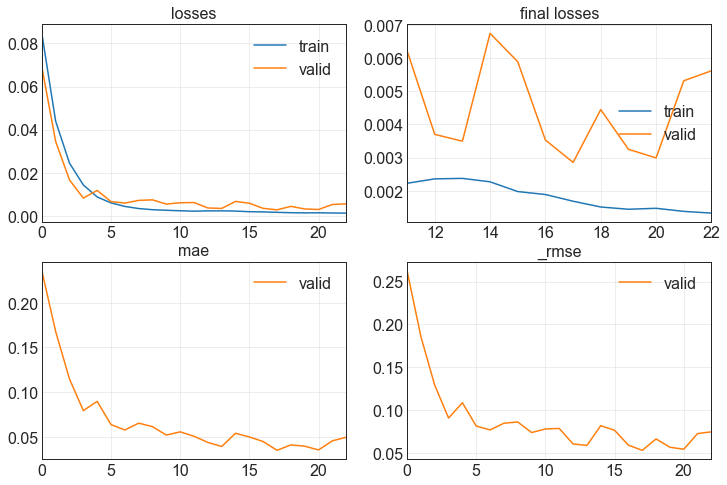

16.36706566810608                                                                                                      
[0.001324991462752223, 0.005620284471660852, 0.04960689693689346, 0.07496856153011322]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 20%|█████████                                    | 10/50 [04:11<13:28, 20.22s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.011688,0.007569,0.055853,0.086998,00:00
1,0.006691,0.009418,0.066326,0.097045,00:00
2,0.004210,0.005599,0.046175,0.074830,00:00
3,0.003626,0.010948,0.072001,0.104632,00:00
4,0.003681,0.008369,0.056555,0.091485,00:00
5,0.003310,0.007260,0.052185,0.085206,00:00
6,0.002860,0.005310,0.046433,0.072872,00:00
7,0.002328,0.002843,0.032158,0.053320,00:00
8,0.002118,0.003878,0.036794,0.062277,00:00
9,0.002136,0.003339,0.034272,0.057784,00:00


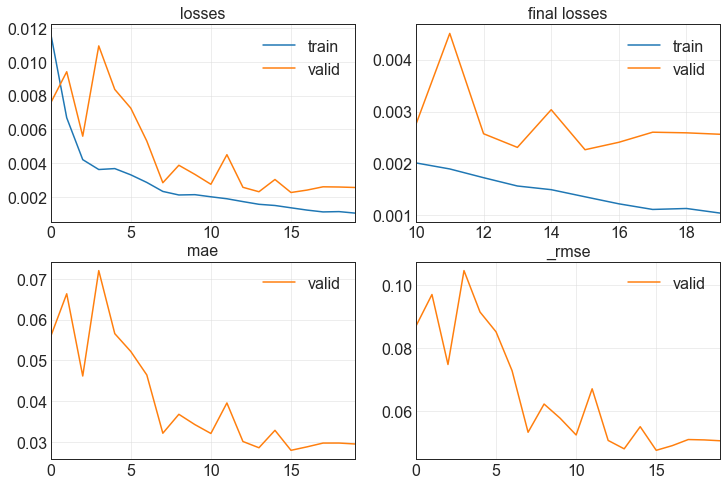

14.192838668823242                                                                                                     
[0.0010441779159009457, 0.0025620462838560343, 0.029518973082304, 0.050616659224033356]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 22%|█████████▉                                   | 11/50 [04:26<12:04, 18.58s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.074790,0.077724,0.244364,0.278789,00:00
1,0.038637,0.035375,0.168379,0.188082,00:00
2,0.021631,0.015663,0.108281,0.125152,00:00
3,0.012897,0.012847,0.092006,0.113344,00:00
4,0.007837,0.008583,0.075707,0.092646,00:00
5,0.005327,0.007861,0.072024,0.088661,00:00
6,0.004195,0.004273,0.050317,0.065369,00:00
7,0.003285,0.006153,0.059314,0.078438,00:00
8,0.002615,0.005587,0.055280,0.074749,00:00
9,0.002322,0.004527,0.049828,0.067284,00:00


No improvement since epoch 32: early stopping                                                                          
 22%|█████████▉                                   | 11/50 [04:55<12:04, 18.58s/trial, best loss: 0.0025544650852680206]

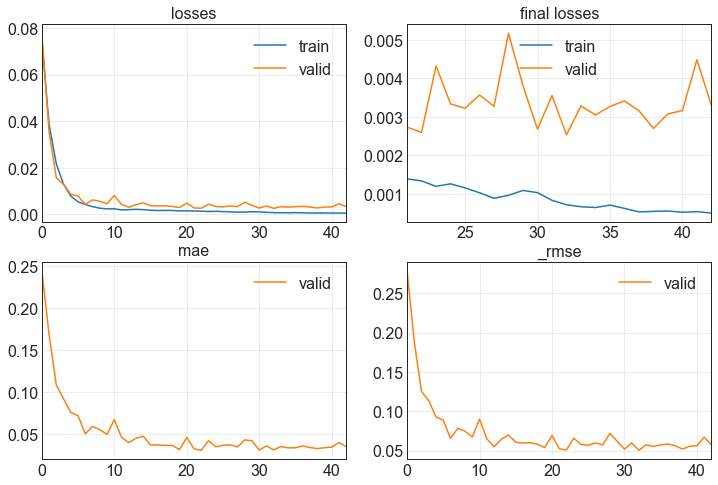

30.167372941970825                                                                                                     
[0.0004990063607692719, 0.0032935526687651873, 0.03512600436806679, 0.057389479130506516]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 24%|██████████▊                                  | 12/50 [04:56<14:04, 22.21s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.078841,0.093092,0.281040,0.305110,00:00
1,0.041738,0.020637,0.127751,0.143655,00:00
2,0.024364,0.005956,0.054276,0.077173,00:00
3,0.015187,0.004108,0.046972,0.064096,00:00
4,0.010050,0.007885,0.059005,0.088796,00:00
5,0.007297,0.007387,0.061821,0.085945,00:00
6,0.005349,0.003265,0.039862,0.057140,00:00
7,0.004071,0.008071,0.061838,0.089837,00:00
8,0.003357,0.003226,0.041074,0.056798,00:00
9,0.002750,0.004564,0.044085,0.067558,00:00


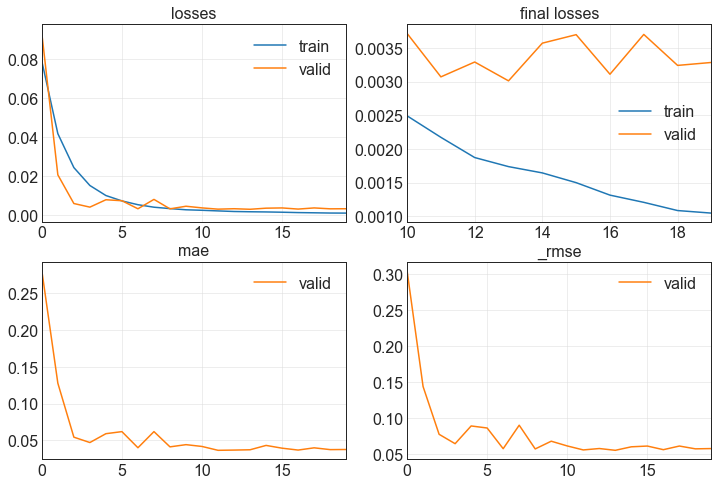

7.778652667999268                                                                                                      
[0.0010470394045114517, 0.0032847265247255564, 0.037493761628866196, 0.05731253698468208]                              
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 26%|███████████▋                                 | 13/50 [05:05<11:07, 18.05s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.023511,0.017737,0.119206,0.133181,00:02
1,0.008425,0.008346,0.074506,0.091354,00:02
2,0.005492,0.005209,0.050179,0.072175,00:02
3,0.004456,0.004417,0.045422,0.066464,00:02
4,0.002867,0.004813,0.045240,0.069374,00:02
5,0.002742,0.003788,0.043210,0.061546,00:02
6,0.003038,0.002555,0.033850,0.050551,00:02
7,0.002306,0.003770,0.035877,0.061402,00:02
8,0.002477,0.002586,0.030917,0.050851,00:02
9,0.001838,0.003972,0.039495,0.063028,00:02


No improvement since epoch 6: early stopping                                                                           
 26%|███████████▋                                 | 13/50 [05:37<11:07, 18.05s/trial, best loss: 0.0025544650852680206]

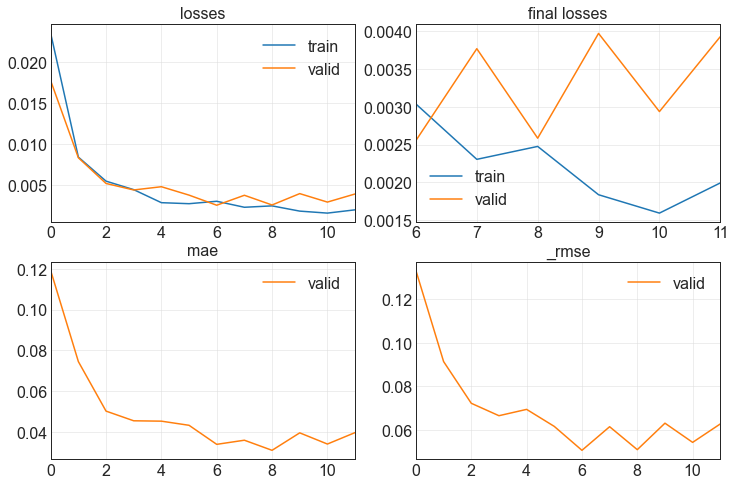

32.53452014923096                                                                                                      
[0.001994013786315918, 0.00392954982817173, 0.039627157151699066, 0.06268612295389175]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
 28%|████████████▌                                | 14/50 [05:38<13:31, 22.55s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.074919,0.071936,0.240120,0.268209,00:00
1,0.036621,0.019773,0.126889,0.140615,00:00
2,0.018650,0.009962,0.081758,0.099810,00:00
3,0.010446,0.006795,0.062216,0.082429,00:00
4,0.006428,0.006386,0.060051,0.079912,00:00
5,0.004436,0.008705,0.068440,0.093301,00:00
6,0.003500,0.005215,0.049954,0.072218,00:00
7,0.003173,0.003725,0.038451,0.061035,00:00
8,0.002549,0.006077,0.049865,0.077953,00:00
9,0.002477,0.007161,0.059087,0.084625,00:00


No improvement since epoch 17: early stopping                                                                          
 28%|████████████▌                                | 14/50 [05:57<13:31, 22.55s/trial, best loss: 0.0025544650852680206]

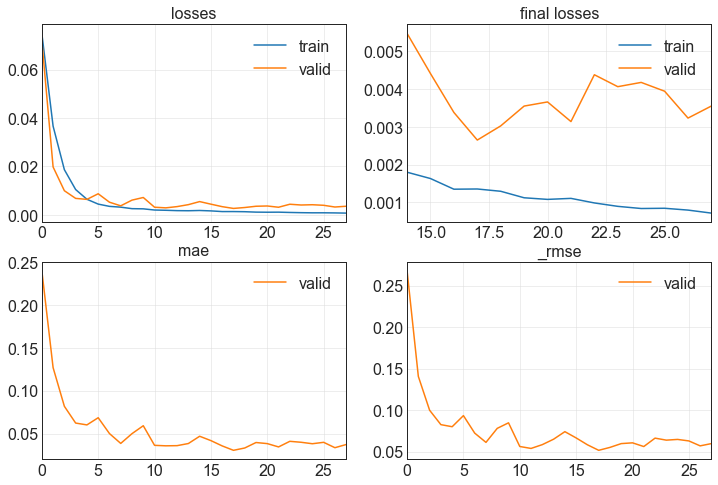

19.746755599975586                                                                                                     
[0.0007157736108638346, 0.0035497983917593956, 0.03715933486819267, 0.059580180794000626]                              
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
 30%|█████████████▌                               | 15/50 [05:58<12:45, 21.87s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.008479,0.005936,0.050839,0.077048,00:01
1,0.004590,0.005004,0.044013,0.070740,00:01
2,0.003410,0.003429,0.035745,0.058559,00:01
3,0.002870,0.003334,0.042615,0.057739,00:01
4,0.003251,0.004375,0.042905,0.066144,00:01
5,0.002405,0.004558,0.049305,0.067513,00:01
6,0.002625,0.004473,0.039365,0.066880,00:01
7,0.002618,0.004022,0.039120,0.063418,00:01
8,0.002572,0.008459,0.056371,0.091975,00:01
9,0.002246,0.003334,0.034654,0.057742,00:01


No improvement since epoch 16: early stopping                                                                          
 30%|█████████████▌                               | 15/50 [06:35<12:45, 21.87s/trial, best loss: 0.0025544650852680206]

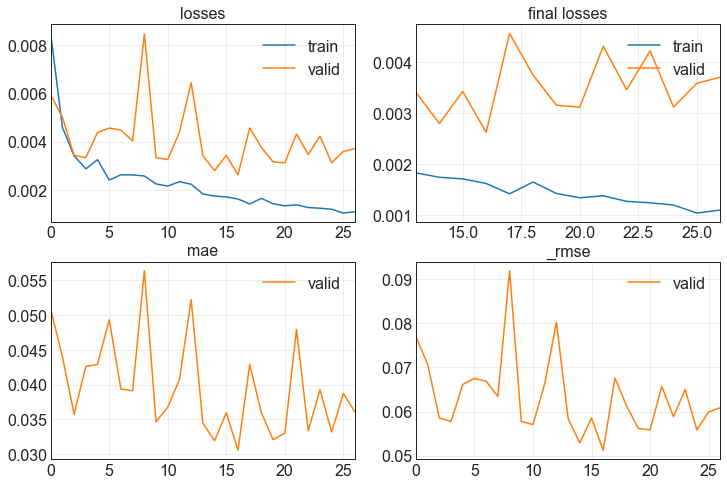

36.890159368515015                                                                                                     
[0.0010963408276438713, 0.0037067069206386805, 0.0360683910548687, 0.06088273227214813]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
 32%|██████████████▍                              | 16/50 [06:36<15:02, 26.54s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.006759,0.010458,0.066204,0.102262,00:02
1,0.005130,0.013769,0.073042,0.117344,00:02
2,0.004013,0.005946,0.048528,0.077107,00:02
3,0.002939,0.003673,0.037312,0.060603,00:02
4,0.003471,0.009822,0.069624,0.099104,00:02
5,0.003295,0.006839,0.049671,0.082701,00:02
6,0.002322,0.005557,0.046117,0.074544,00:02
7,0.002233,0.004589,0.042010,0.067744,00:02
8,0.001861,0.003285,0.037394,0.057313,00:02
9,0.001710,0.002931,0.033150,0.054135,00:02


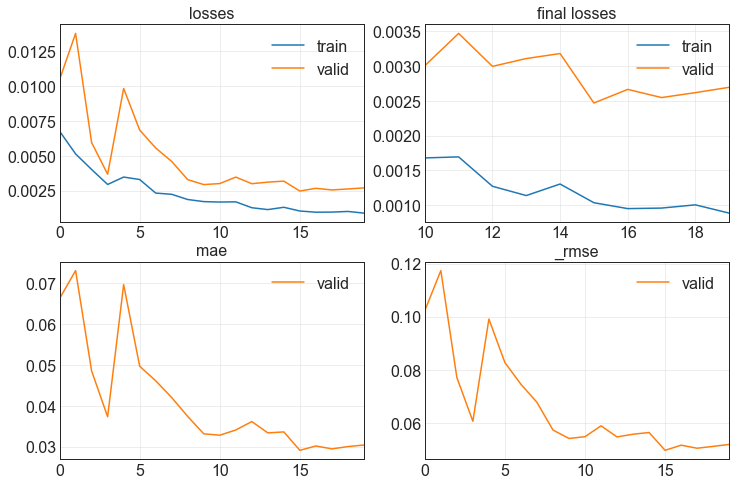

53.92718577384949                                                                                                      
[0.0008860003435984254, 0.0026934719644486904, 0.030413763597607613, 0.05189867317676544]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}    
ResNet                                                                                                                 
 34%|███████████████▎                             | 17/50 [07:30<19:12, 34.91s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.089073,0.122888,0.318190,0.350554,00:00
1,0.057404,0.049466,0.201466,0.222411,00:00
2,0.038523,0.035362,0.165913,0.188048,00:00
3,0.026595,0.019806,0.121115,0.140735,00:00
4,0.018480,0.008790,0.076676,0.093754,00:00
5,0.012950,0.007334,0.067371,0.085636,00:00
6,0.009244,0.005419,0.055213,0.073613,00:00
7,0.006800,0.006598,0.061966,0.081229,00:00
8,0.005403,0.009075,0.067268,0.095265,00:00
9,0.004379,0.004469,0.051204,0.066851,00:00


No improvement since epoch 18: early stopping                                                                          
 34%|███████████████▎                             | 17/50 [07:41<19:12, 34.91s/trial, best loss: 0.0025544650852680206]

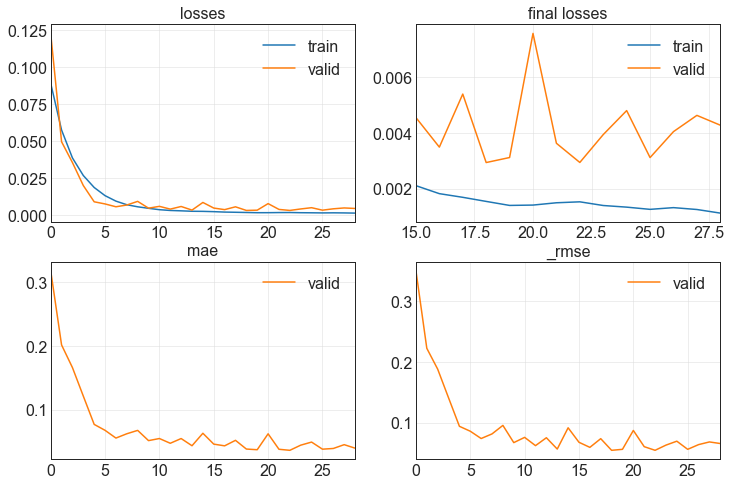

11.149289608001709                                                                                                     
[0.0011233494151383638, 0.004270085599273443, 0.03935283422470093, 0.0653458908200264]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 36%|████████████████▏                            | 18/50 [07:42<14:54, 27.94s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.007645,0.005581,0.048333,0.074709,00:01
1,0.003815,0.006504,0.050746,0.080648,00:01
2,0.002897,0.006925,0.051233,0.083216,00:01
3,0.002641,0.003802,0.042202,0.061661,00:01
4,0.002895,0.004103,0.044000,0.064054,00:01
5,0.002861,0.002706,0.032658,0.052018,00:01
6,0.002511,0.005168,0.050095,0.071889,00:01
7,0.002480,0.006202,0.059590,0.078750,00:01
8,0.002347,0.005467,0.043838,0.073939,00:01
9,0.001997,0.004072,0.041573,0.063809,00:01


No improvement since epoch 5: early stopping                                                                           
 36%|████████████████▏                            | 18/50 [07:56<14:54, 27.94s/trial, best loss: 0.0025544650852680206]

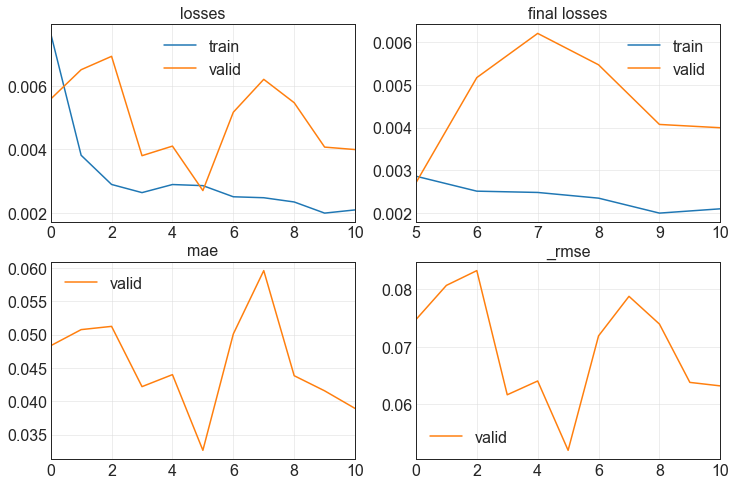

15.302184581756592                                                                                                     
[0.0020976250525563955, 0.003994629718363285, 0.03893475979566574, 0.06320308148860931]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
 38%|█████████████████                            | 19/50 [07:57<12:33, 24.31s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.058151,0.035560,0.174643,0.188574,00:00
1,0.027191,0.013624,0.102142,0.116721,00:00
2,0.013393,0.006811,0.059306,0.082526,00:00
3,0.007418,0.005600,0.053882,0.074832,00:00
4,0.004716,0.008110,0.063250,0.090058,00:00
5,0.003441,0.003396,0.041300,0.058274,00:00
6,0.003095,0.004332,0.043776,0.065816,00:00
7,0.002704,0.004000,0.042401,0.063247,00:00
8,0.002227,0.007125,0.056040,0.084409,00:00
9,0.001901,0.003971,0.040278,0.063017,00:00


No improvement since epoch 15: early stopping                                                                          
 38%|█████████████████                            | 19/50 [08:15<12:33, 24.31s/trial, best loss: 0.0025544650852680206]

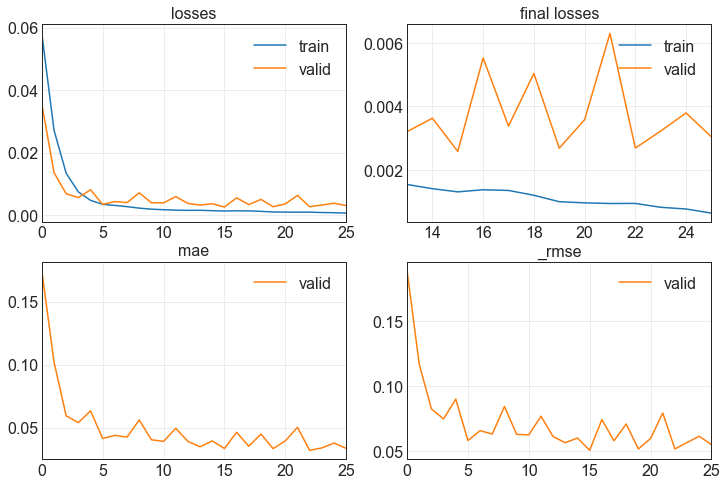

18.36922860145569                                                                                                      
[0.0006349565228447318, 0.0030359162483364344, 0.03348540514707565, 0.05509915202856064]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}      
ResNet                                                                                                                 
 40%|██████████████████                           | 20/50 [08:16<11:20, 22.68s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.088717,0.087166,0.262696,0.295240,00:02
1,0.029363,0.021638,0.132756,0.147099,00:02
2,0.010084,0.011075,0.089065,0.105240,00:02
3,0.005420,0.005459,0.055361,0.073883,00:02
4,0.003656,0.005780,0.054491,0.076027,00:02
5,0.002839,0.004129,0.042242,0.064260,00:02
6,0.002355,0.003335,0.038371,0.057748,00:02
7,0.001936,0.003844,0.039613,0.061999,00:02
8,0.001580,0.004462,0.043751,0.066799,00:02
9,0.001699,0.003063,0.035001,0.055345,00:02


No improvement since epoch 9: early stopping                                                                           
 40%|██████████████████                           | 20/50 [08:56<11:20, 22.68s/trial, best loss: 0.0025544650852680206]

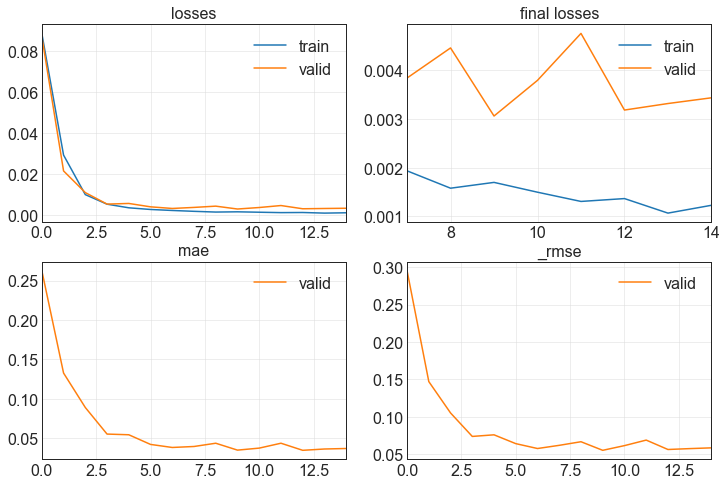

40.5439236164093                                                                                                       
[0.0012284177355468273, 0.003437401494011283, 0.0370657853782177, 0.0586293563246727]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}      
ResNet                                                                                                                 
 42%|██████████████████▉                          | 21/50 [08:57<13:37, 28.20s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.109026,0.105348,0.290876,0.324574,00:02
1,0.031728,0.018438,0.123832,0.135786,00:02
2,0.011701,0.010029,0.082190,0.100146,00:02
3,0.005886,0.009342,0.074952,0.096652,00:02
4,0.004496,0.006752,0.057647,0.082168,00:02
5,0.003970,0.008690,0.064940,0.093218,00:02
6,0.002619,0.006808,0.057193,0.082511,00:02
7,0.002435,0.004428,0.043900,0.066543,00:02
8,0.001874,0.006670,0.052956,0.081672,00:02
9,0.001714,0.003949,0.040297,0.062838,00:02


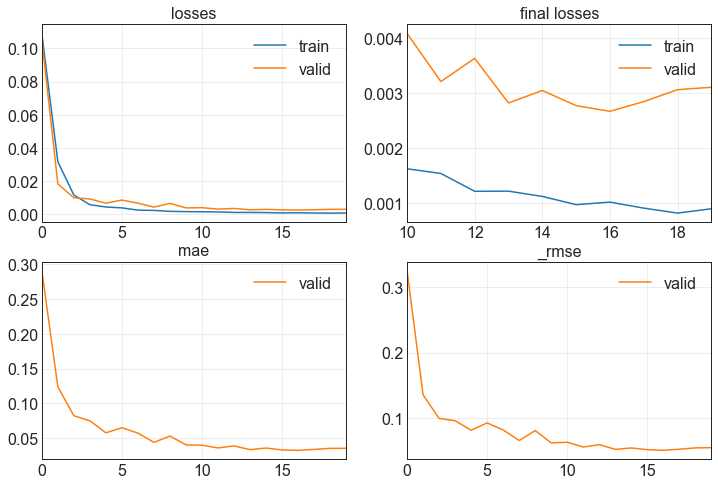

54.19519066810608                                                                                                      
[0.0008978772675618529, 0.0031032119877636433, 0.03538544103503227, 0.055706486105918884]                              
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 44%|███████████████████▊                         | 22/50 [09:52<16:52, 36.16s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.005625,0.006554,0.059223,0.080957,00:02
1,0.004772,0.006253,0.048123,0.079075,00:02
2,0.004811,0.005725,0.049469,0.075663,00:02
3,0.003182,0.005218,0.043127,0.072239,00:02
4,0.003178,0.004085,0.038559,0.063912,00:02
5,0.003144,0.005530,0.056943,0.074367,00:02
6,0.002564,0.003982,0.038222,0.063102,00:02
7,0.002254,0.003632,0.037278,0.060263,00:02
8,0.001980,0.004724,0.040574,0.068729,00:02
9,0.001825,0.003166,0.033386,0.056269,00:02


No improvement since epoch 12: early stopping                                                                          
 44%|███████████████████▊                         | 22/50 [10:41<16:52, 36.16s/trial, best loss: 0.0025544650852680206]

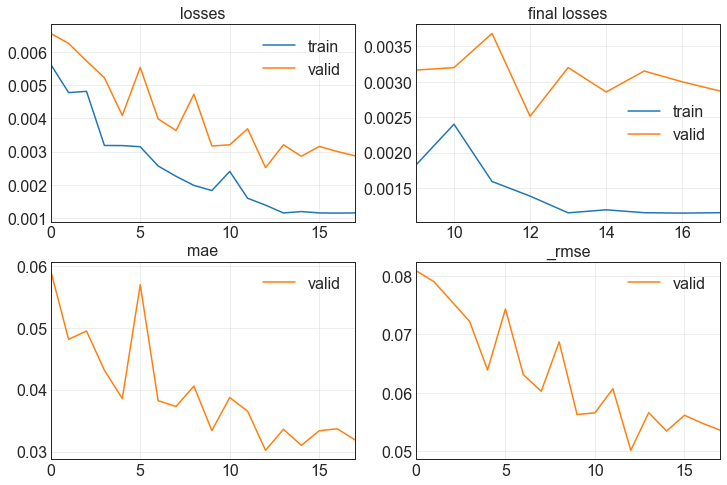

49.54535889625549                                                                                                      
[0.0011521991109475493, 0.0028692663181573153, 0.03188352659344673, 0.053565531969070435]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}      
ResNet                                                                                                                 
 46%|████████████████████▋                        | 23/50 [10:42<18:09, 40.34s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.132083,0.115291,0.307122,0.339545,00:00
1,0.093159,0.078174,0.247622,0.279596,00:00
2,0.052740,0.041377,0.179174,0.203413,00:00
3,0.027901,0.019367,0.119577,0.139165,00:00
4,0.015367,0.012999,0.094742,0.114013,00:00
5,0.009264,0.011038,0.084135,0.105064,00:00
6,0.006158,0.008013,0.071285,0.089517,00:00
7,0.004432,0.007925,0.070218,0.089025,00:00
8,0.003330,0.008217,0.068195,0.090650,00:00
9,0.002685,0.006371,0.062163,0.079818,00:00


No improvement since epoch 14: early stopping                                                                          
 46%|████████████████████▋                        | 23/50 [10:56<18:09, 40.34s/trial, best loss: 0.0025544650852680206]

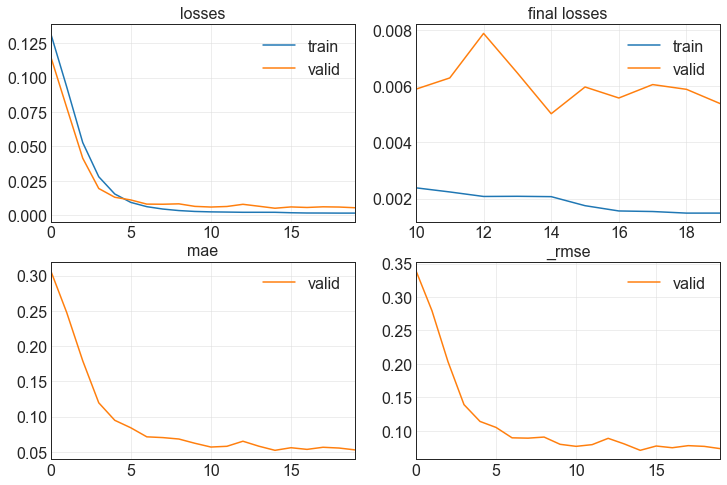

14.216516256332397                                                                                                     
[0.0014802560908719897, 0.005376930348575115, 0.052770063281059265, 0.07332755625247955]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
 48%|█████████████████████▌                       | 24/50 [10:57<14:09, 32.67s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.009143,0.011227,0.088442,0.105959,00:02
1,0.004723,0.011416,0.068193,0.106847,00:02
2,0.004518,0.012148,0.072104,0.110217,00:02
3,0.003518,0.008550,0.057393,0.092464,00:02
4,0.003373,0.004432,0.047188,0.066576,00:02
5,0.003187,0.004565,0.040579,0.067566,00:02
6,0.002741,0.005234,0.044331,0.072349,00:02
7,0.002339,0.005113,0.042210,0.071508,00:02
8,0.002262,0.005223,0.043153,0.072271,00:02
9,0.001883,0.005504,0.043831,0.074186,00:02


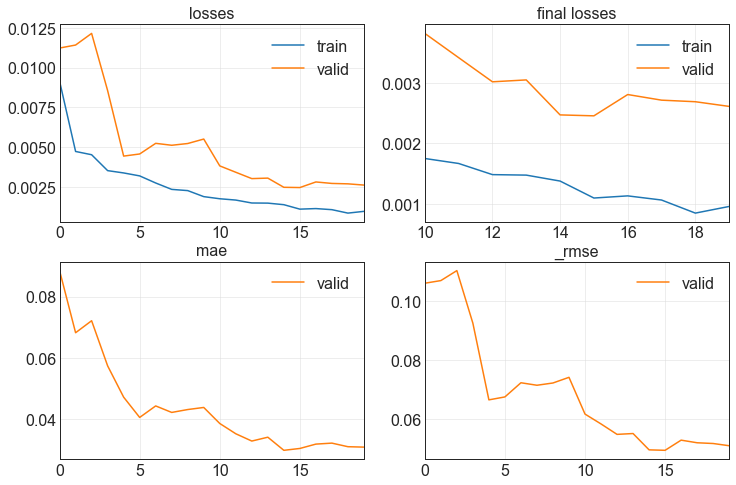

53.88866400718689                                                                                                      
[0.0009567986126057804, 0.0026097819209098816, 0.03090323507785797, 0.051086023449897766]                              
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 50%|██████████████████████▌                      | 25/50 [11:51<16:19, 39.19s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.012602,0.008715,0.062662,0.093352,00:01
1,0.006042,0.006884,0.050891,0.082972,00:01
2,0.004331,0.013607,0.068943,0.116650,00:01
3,0.004139,0.005887,0.047247,0.076729,00:01
4,0.002932,0.003084,0.035095,0.055533,00:01
5,0.003113,0.004263,0.045996,0.065292,00:01
6,0.003070,0.003857,0.041317,0.062108,00:01
7,0.002794,0.003951,0.039307,0.062861,00:01
8,0.002200,0.004832,0.042680,0.069512,00:01
9,0.002107,0.003390,0.034949,0.058220,00:01


No improvement since epoch 4: early stopping                                                                           
 50%|██████████████████████▌                      | 25/50 [12:05<16:19, 39.19s/trial, best loss: 0.0025544650852680206]

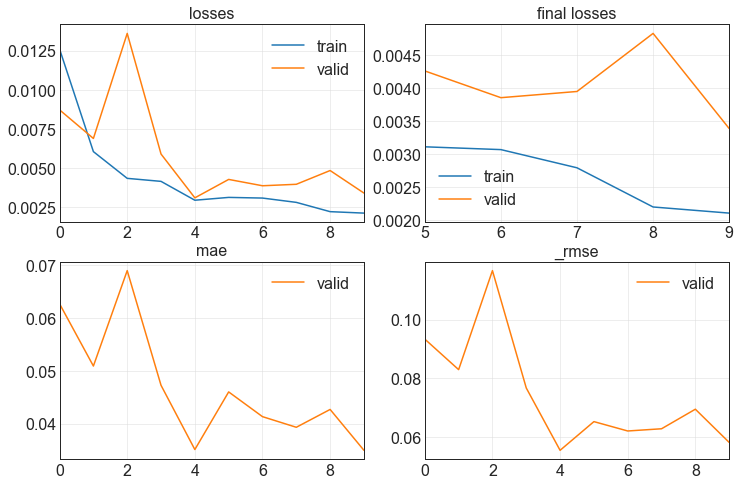

13.910060405731201                                                                                                     
[0.002107345499098301, 0.0033896053209900856, 0.03494922071695328, 0.05822031572461128]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 52%|███████████████████████▍                     | 26/50 [12:06<12:42, 31.77s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.020638,0.005738,0.056836,0.075751,00:00
1,0.009723,0.008868,0.066050,0.094172,00:00
2,0.006465,0.006793,0.049453,0.082422,00:00
3,0.004704,0.011496,0.065917,0.107221,00:00
4,0.003966,0.008976,0.062599,0.094740,00:00
5,0.003071,0.003596,0.042177,0.059966,00:00
6,0.002598,0.006708,0.050041,0.081902,00:00
7,0.002424,0.003627,0.038500,0.060224,00:00
8,0.002004,0.003195,0.037746,0.056520,00:00
9,0.001866,0.003653,0.036252,0.060443,00:00


No improvement since epoch 8: early stopping                                                                           
 52%|███████████████████████▍                     | 26/50 [12:15<12:42, 31.77s/trial, best loss: 0.0025544650852680206]

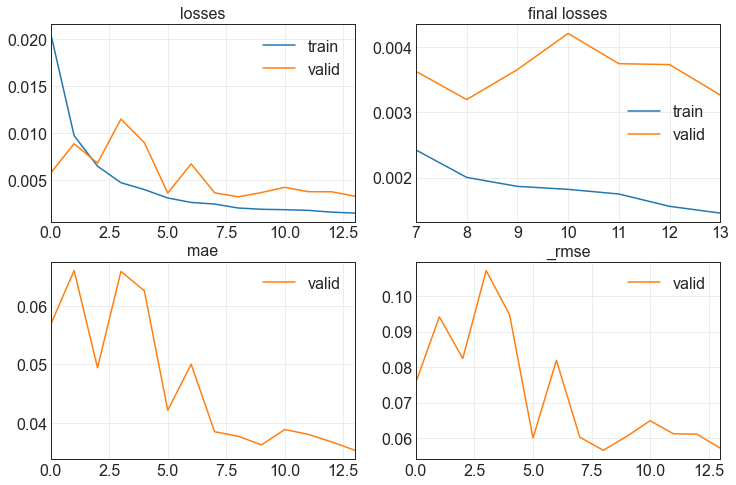

10.041236877441406                                                                                                     
[0.0014570985222235322, 0.0032638218253850937, 0.0353243388235569, 0.057129867374897]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 54%|████████████████████████▎                    | 27/50 [12:16<09:44, 25.41s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.098374,0.086760,0.270984,0.294550,00:00
1,0.069242,0.048356,0.198702,0.219900,00:00
2,0.038485,0.017522,0.120017,0.132369,00:00
3,0.021047,0.010995,0.087365,0.104858,00:00
4,0.011926,0.006641,0.068620,0.081494,00:00
5,0.007387,0.007908,0.069940,0.088929,00:00
6,0.004849,0.005269,0.056897,0.072587,00:00
7,0.003795,0.004657,0.052988,0.068241,00:00
8,0.003097,0.005090,0.053741,0.071347,00:00
9,0.002648,0.004606,0.049942,0.067868,00:00


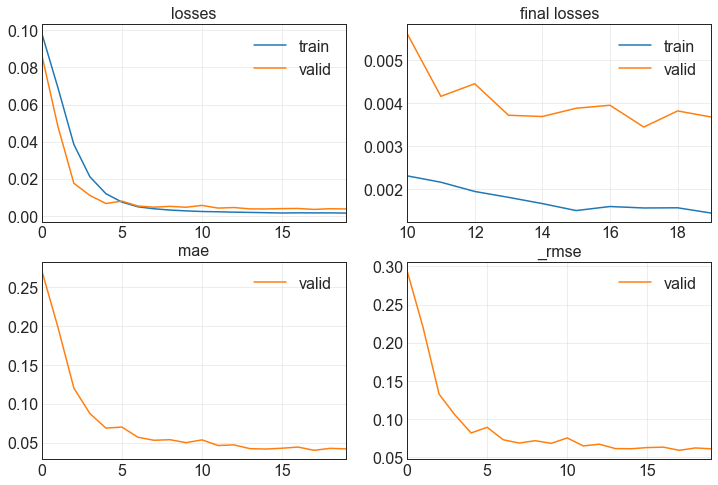

14.20121145248413                                                                                                      
[0.001451222226023674, 0.0036779213696718216, 0.041865427047014236, 0.06064586713910103]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
 56%|█████████████████████████▏                   | 28/50 [12:31<08:08, 22.21s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.006687,0.005483,0.047523,0.074046,00:02
1,0.005533,0.010749,0.078803,0.103676,00:02
2,0.004616,0.018908,0.113922,0.137507,00:02
3,0.003568,0.004913,0.042371,0.070090,00:02
4,0.003478,0.007947,0.056497,0.089147,00:02
5,0.002856,0.006310,0.044725,0.079433,00:02
6,0.002919,0.004078,0.039814,0.063860,00:02
7,0.002138,0.003764,0.037748,0.061352,00:02
8,0.002060,0.003440,0.036877,0.058652,00:02
9,0.001662,0.003679,0.037515,0.060651,00:02


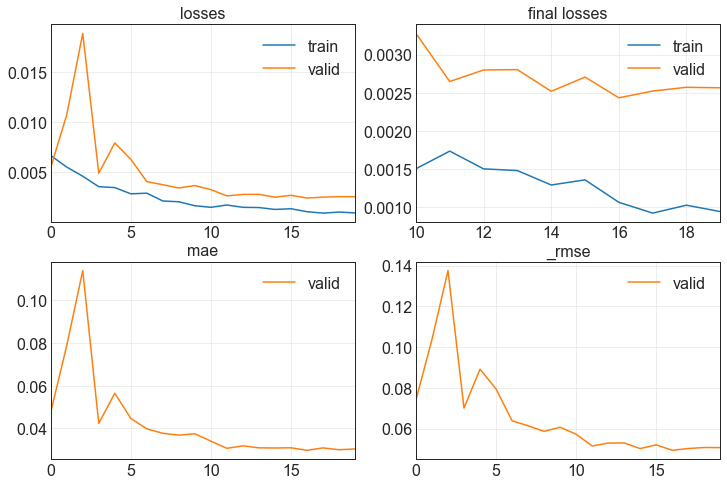

53.78802967071533                                                                                                      
[0.000945218198467046, 0.0025648747105151415, 0.030412856489419937, 0.05064459517598152]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 58%|██████████████████████████                   | 29/50 [13:26<11:08, 31.84s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.007179,0.008094,0.064774,0.089965,00:02
1,0.004299,0.009175,0.060609,0.095789,00:02
2,0.004199,0.006534,0.053098,0.080832,00:02
3,0.003701,0.005551,0.043474,0.074503,00:02
4,0.003328,0.008062,0.066884,0.089788,00:02
5,0.002966,0.004698,0.042743,0.068546,00:02
6,0.002711,0.004171,0.040041,0.064585,00:02
7,0.002210,0.003786,0.036154,0.061527,00:02
8,0.001709,0.004199,0.038504,0.064801,00:02
9,0.002268,0.003561,0.037832,0.059671,00:02


No improvement since epoch 11: early stopping                                                                          
 58%|██████████████████████████                   | 29/50 [14:11<11:08, 31.84s/trial, best loss: 0.0025544650852680206]

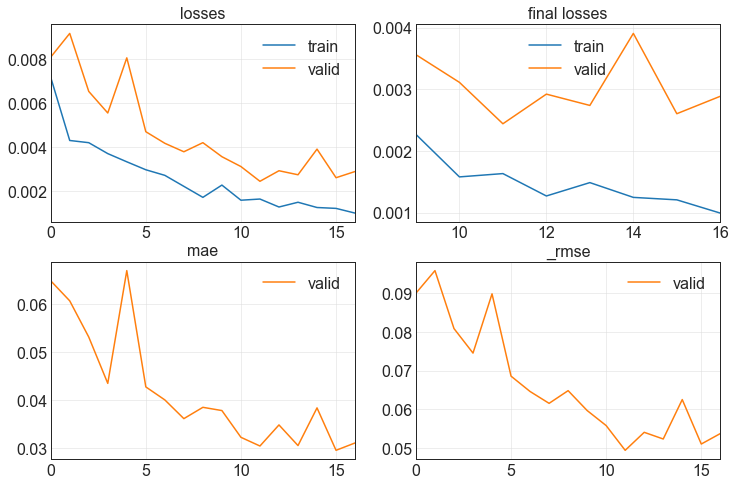

45.7606098651886                                                                                                       
[0.0009916112758219242, 0.002886321861296892, 0.031109891831874847, 0.0537245012819767]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
 60%|███████████████████████████                  | 30/50 [14:12<12:03, 36.18s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.017250,0.005914,0.053505,0.076905,00:00
1,0.007815,0.007972,0.055022,0.089288,00:00
2,0.005004,0.003691,0.040324,0.060751,00:00
3,0.003780,0.003940,0.035051,0.062773,00:00
4,0.002885,0.005440,0.043228,0.073760,00:00
5,0.002615,0.008855,0.058824,0.094099,00:00
6,0.002802,0.005502,0.045715,0.074176,00:00
7,0.002359,0.002976,0.034293,0.054552,00:00
8,0.002212,0.057310,0.148642,0.239395,00:00
9,0.002095,0.002765,0.031701,0.052581,00:00


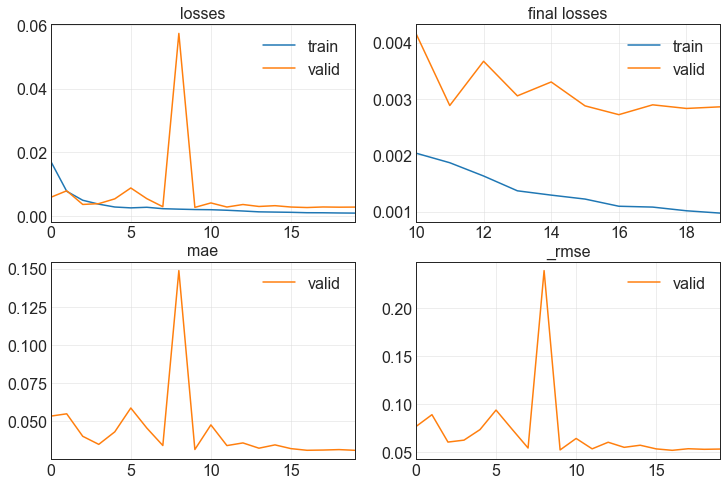

14.172651290893555                                                                                                     
[0.000974106602370739, 0.0028607859276235104, 0.03115915320813656, 0.053486309945583344]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}       
ResNet                                                                                                                 
 62%|███████████████████████████▉                 | 31/50 [14:27<09:25, 29.75s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.008083,0.006812,0.053647,0.082535,00:01
1,0.004705,0.004534,0.041834,0.067333,00:01
2,0.004593,0.011615,0.067461,0.107775,00:01
3,0.003915,0.006117,0.053879,0.078214,00:01
4,0.003201,0.005629,0.045726,0.075024,00:01
5,0.002960,0.003653,0.036405,0.060443,00:01
6,0.002452,0.005184,0.045215,0.072001,00:01
7,0.002239,0.003149,0.035293,0.056115,00:01
8,0.002337,0.002943,0.034203,0.054250,00:01
9,0.001901,0.004083,0.038848,0.063901,00:01


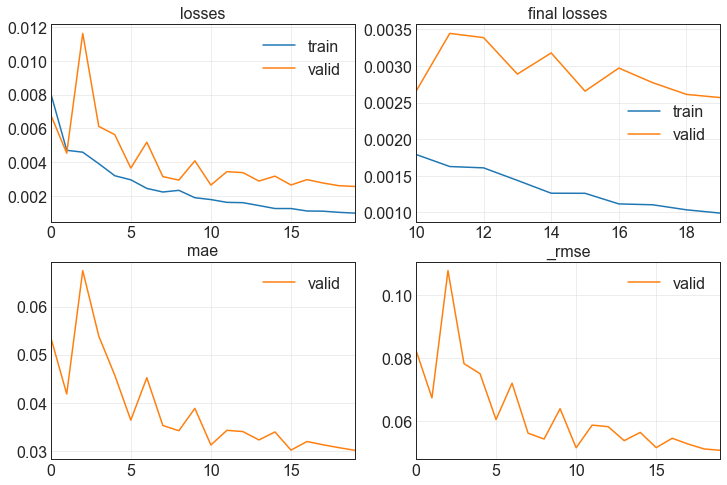

27.345877170562744                                                                                                     
[0.000991323497146368, 0.0025671981275081635, 0.030134689062833786, 0.050667524337768555]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 64%|████████████████████████████▊                | 32/50 [14:54<08:45, 29.19s/trial, best loss: 0.0025544650852680206]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.025579,0.032655,0.137685,0.180707,00:00
1,0.013150,0.004981,0.051238,0.070579,00:00
2,0.008476,0.012058,0.067482,0.109809,00:00
3,0.006570,0.011011,0.064127,0.104931,00:00
4,0.005258,0.007349,0.056502,0.085725,00:00
5,0.004160,0.006926,0.051126,0.083220,00:00
6,0.003401,0.002987,0.033870,0.054653,00:00
7,0.002901,0.003590,0.036393,0.059915,00:00
8,0.002721,0.002935,0.032730,0.054172,00:00
9,0.002297,0.003969,0.039024,0.062996,00:00


No improvement since epoch 14: early stopping                                                                          
 64%|████████████████████████████▊                | 32/50 [15:02<08:45, 29.19s/trial, best loss: 0.0025544650852680206]

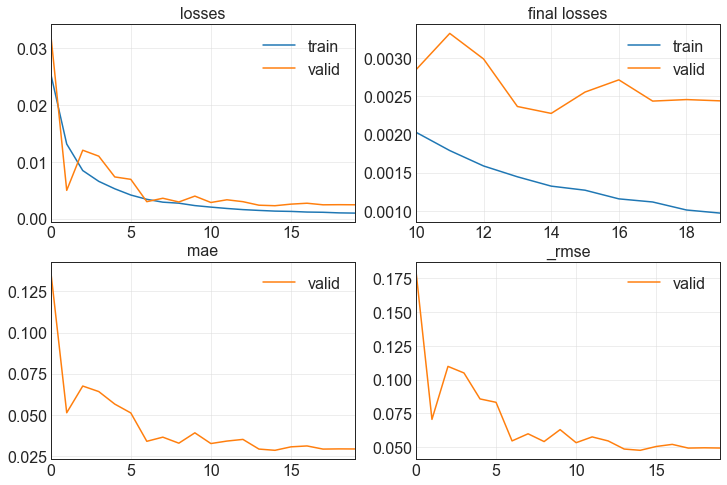

7.7844929695129395                                                                                                     
[0.000970860302913934, 0.0024380148388445377, 0.029207872226834297, 0.04937625676393509]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 66%|█████████████████████████████▋               | 33/50 [15:03<06:29, 22.93s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.029049,0.037852,0.133055,0.194555,00:00
1,0.014328,0.040996,0.149856,0.202473,00:00
2,0.009773,0.009942,0.060286,0.099710,00:00
3,0.007124,0.011250,0.070376,0.106067,00:00
4,0.005471,0.004729,0.041603,0.068769,00:00
5,0.004532,0.002764,0.035878,0.052578,00:00
6,0.003918,0.006513,0.056169,0.080703,00:00
7,0.003169,0.004781,0.041750,0.069144,00:00
8,0.002703,0.004650,0.039926,0.068192,00:00
9,0.002296,0.003234,0.034218,0.056869,00:00


No improvement since epoch 5: early stopping                                                                           
 66%|█████████████████████████████▋               | 33/50 [15:07<06:29, 22.93s/trial, best loss: 0.0024380148388445377]

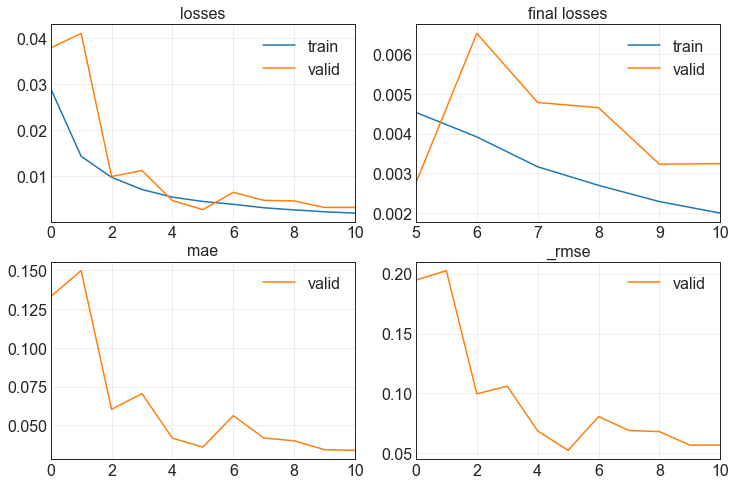

4.501819133758545                                                                                                      
[0.002006764290854335, 0.0032467148266732693, 0.03378550335764885, 0.0569799542427063]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}   
ResNet                                                                                                                 
 68%|██████████████████████████████▌              | 34/50 [15:08<04:40, 17.56s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.123571,0.150819,0.349347,0.388354,00:00
1,0.114451,0.115175,0.307785,0.339375,00:00
2,0.104498,0.091696,0.275267,0.302813,00:00
3,0.093369,0.079555,0.255131,0.282055,00:00
4,0.080947,0.067809,0.234169,0.260402,00:00
5,0.067881,0.054706,0.210414,0.233892,00:00
6,0.055417,0.044084,0.189360,0.209962,00:00
7,0.043824,0.031885,0.161991,0.178564,00:00
8,0.034132,0.024021,0.140798,0.154988,00:00
9,0.026276,0.017639,0.119538,0.132812,00:00


No improvement since epoch 41: early stopping                                                                          
 68%|██████████████████████████████▌              | 34/50 [15:27<04:40, 17.56s/trial, best loss: 0.0024380148388445377]

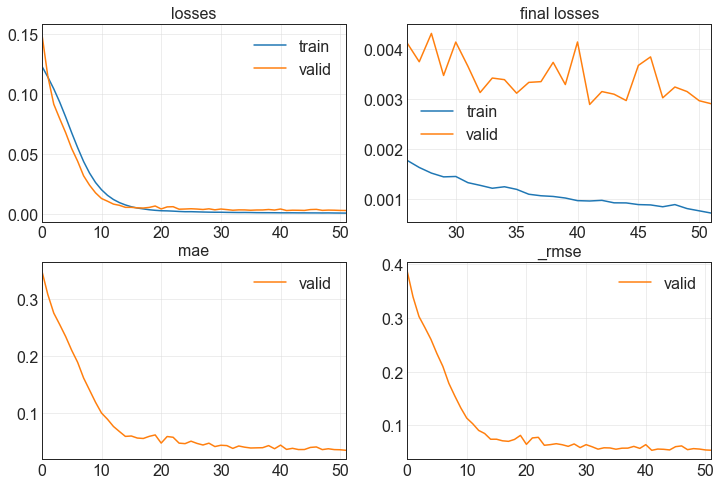

19.56389832496643                                                                                                      
[0.0007227749447338283, 0.0029029108118265867, 0.035748597234487534, 0.053878672420978546]                             
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
 70%|███████████████████████████████▍             | 35/50 [15:28<04:34, 18.32s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.033901,0.029273,0.133918,0.171095,00:00
1,0.016385,0.021375,0.105504,0.146201,00:00
2,0.010909,0.025784,0.131212,0.160575,00:00
3,0.007737,0.019127,0.119976,0.138301,00:00
4,0.005932,0.009755,0.069332,0.098766,00:00
5,0.004923,0.003237,0.035818,0.056892,00:00
6,0.004087,0.004544,0.049749,0.067408,00:00
7,0.003368,0.004015,0.040660,0.063362,00:00
8,0.002833,0.003398,0.033842,0.058292,00:00
9,0.002451,0.003439,0.034559,0.058642,00:00


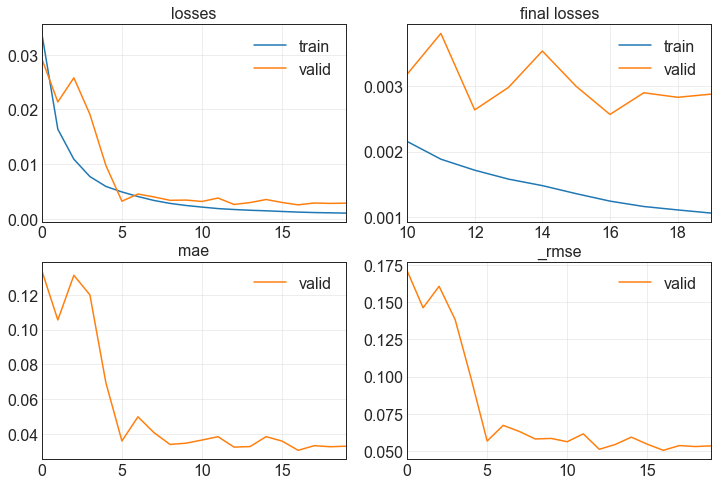

7.759827613830566                                                                                                      
[0.0010568301659077406, 0.002880525542423129, 0.03283081203699112, 0.053670529276132584]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 72%|████████████████████████████████▍            | 36/50 [15:36<03:34, 15.31s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.027252,0.048227,0.156844,0.219606,00:00
1,0.013414,0.015552,0.078826,0.124709,00:00
2,0.009116,0.011503,0.067606,0.107254,00:00
3,0.007071,0.019060,0.093458,0.138059,00:00
4,0.005588,0.009508,0.066705,0.097508,00:00
5,0.004449,0.006387,0.054101,0.079921,00:00
6,0.003680,0.002839,0.040365,0.053283,00:00
7,0.003121,0.005715,0.047550,0.075595,00:00
8,0.002623,0.003893,0.038941,0.062394,00:00
9,0.002317,0.006249,0.052037,0.079053,00:00


No improvement since epoch 11: early stopping                                                                          
 72%|████████████████████████████████▍            | 36/50 [15:42<03:34, 15.31s/trial, best loss: 0.0024380148388445377]

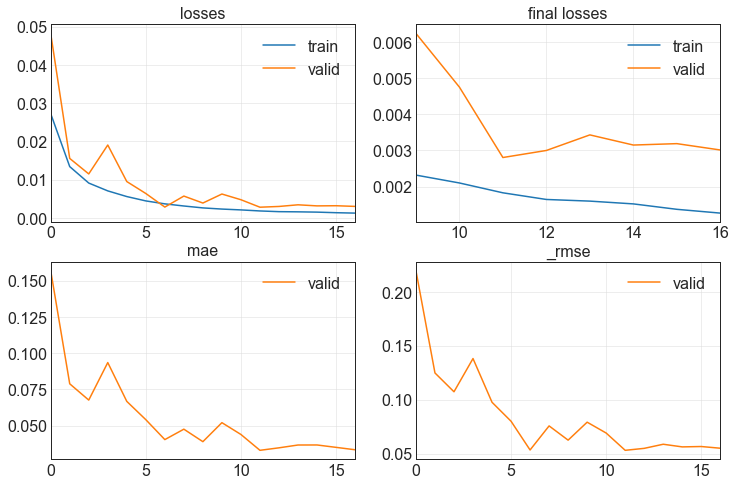

6.644209861755371                                                                                                      
[0.0012623855145648122, 0.0030138588044792414, 0.03336421400308609, 0.05489862337708473]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}      
ResNet                                                                                                                 
 74%|█████████████████████████████████▎           | 37/50 [15:43<02:47, 12.87s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.024418,0.033769,0.159722,0.183762,00:00
1,0.012386,0.004934,0.050632,0.070241,00:00
2,0.007903,0.005110,0.053820,0.071483,00:00
3,0.005513,0.004496,0.045220,0.067051,00:00
4,0.004403,0.006162,0.055959,0.078499,00:00
5,0.003677,0.006461,0.051255,0.080381,00:00
6,0.003233,0.003362,0.037703,0.057983,00:00
7,0.002771,0.005503,0.054016,0.074184,00:00
8,0.002578,0.010463,0.070426,0.102287,00:00
9,0.002496,0.005234,0.052215,0.072345,00:00


No improvement since epoch 6: early stopping                                                                           
 74%|█████████████████████████████████▎           | 37/50 [15:48<02:47, 12.87s/trial, best loss: 0.0024380148388445377]

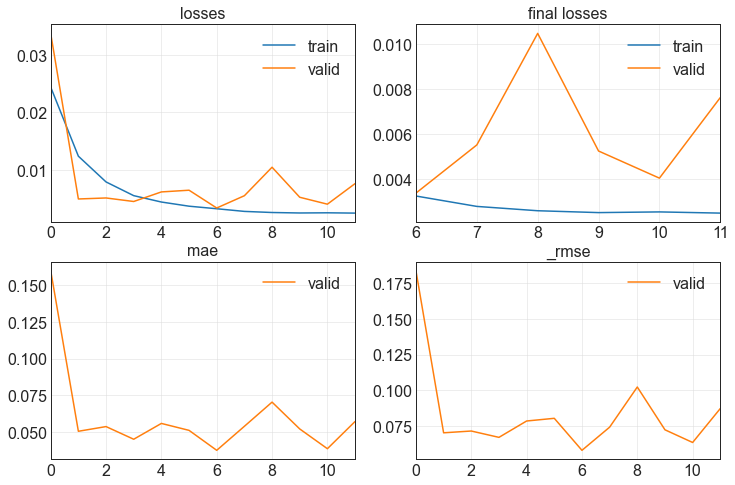

4.873885631561279                                                                                                      
[0.0024731052108108997, 0.007610154338181019, 0.05726682394742966, 0.0872361958026886]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
 76%|██████████████████████████████████▏          | 38/50 [15:49<02:07, 10.63s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.024275,0.033708,0.172725,0.183597,00:00
1,0.012532,0.006728,0.054813,0.082022,00:00
2,0.008457,0.013096,0.086495,0.114436,00:00
3,0.006271,0.007008,0.052180,0.083717,00:00
4,0.004699,0.002904,0.039083,0.053888,00:00
5,0.003896,0.003144,0.034690,0.056071,00:00
6,0.003469,0.008890,0.060807,0.094288,00:00
7,0.003073,0.008460,0.055224,0.091979,00:00
8,0.003037,0.007439,0.058967,0.086250,00:00
9,0.002948,0.007067,0.050095,0.084068,00:00


No improvement since epoch 4: early stopping                                                                           
 76%|██████████████████████████████████▏          | 38/50 [15:54<02:07, 10.63s/trial, best loss: 0.0024380148388445377]

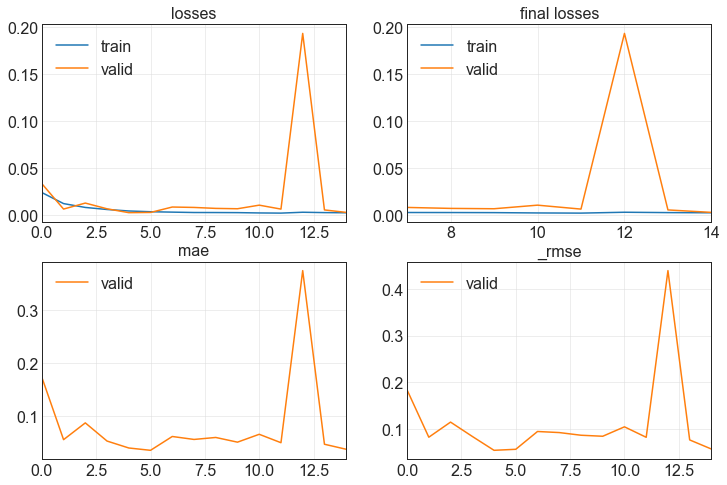

5.956108331680298                                                                                                      
[0.0027982667088508606, 0.0032061925157904625, 0.03667028248310089, 0.05662325397133827]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}      
ResNet                                                                                                                 
 78%|███████████████████████████████████          | 39/50 [15:55<01:43,  9.39s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.113722,0.118779,0.310774,0.344643,00:02
1,0.034818,0.029640,0.157741,0.172164,00:02
2,0.012941,0.007534,0.072461,0.086797,00:02
3,0.006577,0.008274,0.075605,0.090960,00:02
4,0.004309,0.008440,0.066134,0.091869,00:02
5,0.003075,0.006508,0.059415,0.080674,00:02
6,0.003070,0.004617,0.048357,0.067952,00:02
7,0.002257,0.003925,0.042021,0.062649,00:02
8,0.001834,0.003091,0.038325,0.055595,00:02
9,0.001771,0.003273,0.039235,0.057214,00:02


No improvement since epoch 14: early stopping                                                                          
 78%|███████████████████████████████████          | 39/50 [16:49<01:43,  9.39s/trial, best loss: 0.0024380148388445377]

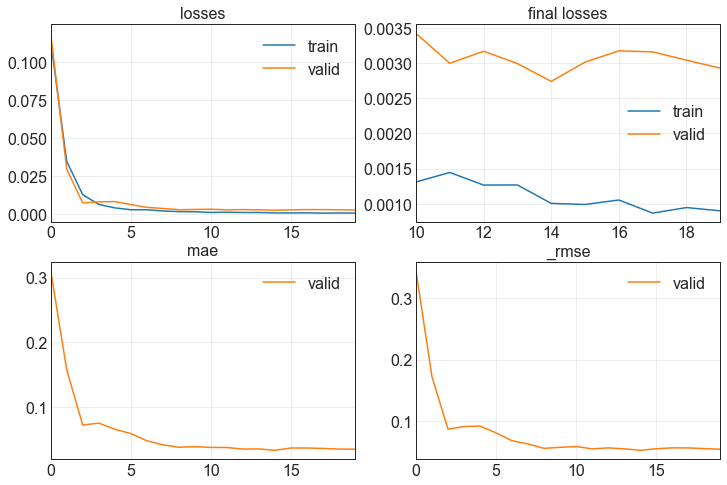

53.82655715942383                                                                                                      
[0.0008995039970614016, 0.0029294677078723907, 0.035346340388059616, 0.05412455275654793]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 80%|████████████████████████████████████         | 40/50 [16:50<03:48, 22.88s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.032080,0.039416,0.167393,0.198535,00:00
1,0.015766,0.008339,0.060499,0.091318,00:00
2,0.009826,0.007729,0.059373,0.087913,00:00
3,0.006660,0.005405,0.047581,0.073519,00:00
4,0.004976,0.004308,0.044910,0.065637,00:00
5,0.004029,0.006326,0.055996,0.079534,00:00
6,0.003393,0.006745,0.057389,0.082129,00:00
7,0.002850,0.003945,0.039919,0.062810,00:00
8,0.002674,0.004979,0.047556,0.070563,00:00
9,0.002595,0.004243,0.046063,0.065141,00:00


No improvement since epoch 14: early stopping                                                                          
 80%|████████████████████████████████████         | 40/50 [16:59<03:48, 22.88s/trial, best loss: 0.0024380148388445377]

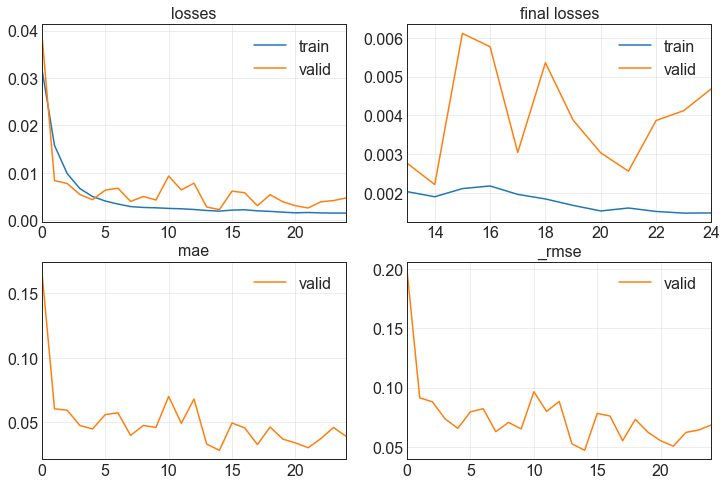

9.65777063369751                                                                                                       
[0.0014819519128650427, 0.004686943255364895, 0.039103731513023376, 0.06846125423908234]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 82%|████████████████████████████████████▉        | 41/50 [17:00<02:51, 19.07s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.005511,0.008437,0.059671,0.091854,00:02
1,0.005873,0.009852,0.061509,0.099258,00:02
2,0.004289,0.013834,0.091921,0.117617,00:02
3,0.003436,0.013004,0.083226,0.114034,00:02
4,0.003371,0.005494,0.045260,0.074119,00:02
5,0.002686,0.007976,0.054600,0.089307,00:02
6,0.002811,0.005340,0.046657,0.073078,00:02
7,0.002127,0.003841,0.036720,0.061976,00:02
8,0.002122,0.005957,0.046763,0.077184,00:02
9,0.002086,0.003187,0.033454,0.056451,00:02


No improvement since epoch 14: early stopping                                                                          
 82%|████████████████████████████████████▉        | 41/50 [17:53<02:51, 19.07s/trial, best loss: 0.0024380148388445377]

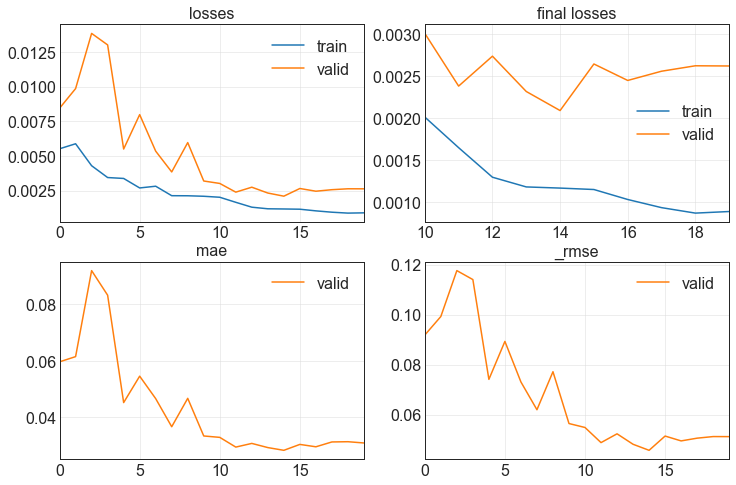

53.86736559867859                                                                                                      
[0.0008901035762391984, 0.002623123349621892, 0.030979102477431297, 0.05121643468737602]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
 84%|█████████████████████████████████████▊       | 42/50 [17:54<03:57, 29.67s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.025651,0.043752,0.147590,0.209170,00:00
1,0.012979,0.033528,0.120907,0.183107,00:00
2,0.008927,0.013392,0.073949,0.115724,00:00
3,0.006760,0.006352,0.054893,0.079699,00:00
4,0.005326,0.011069,0.066965,0.105207,00:00
5,0.004160,0.002676,0.034536,0.051730,00:00
6,0.003293,0.002762,0.032634,0.052552,00:00
7,0.002987,0.002705,0.032833,0.052011,00:00
8,0.002561,0.003854,0.039737,0.062079,00:00
9,0.002283,0.005716,0.048099,0.075602,00:00


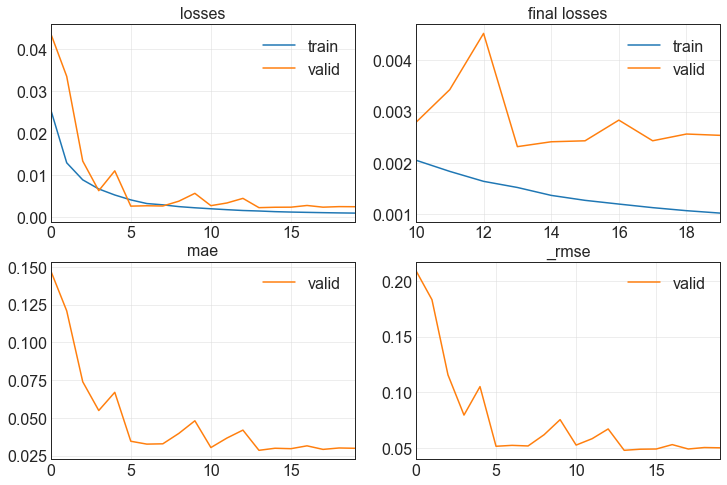

7.7461488246917725                                                                                                     
[0.0010178640950471163, 0.0025348325725644827, 0.02986985445022583, 0.050347115844488144]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}      
ResNet                                                                                                                 
 86%|██████████████████████████████████████▋      | 43/50 [18:03<02:42, 23.25s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.046586,0.030655,0.153353,0.175085,00:00
1,0.021680,0.027081,0.104909,0.164563,00:00
2,0.013715,0.014185,0.081283,0.119100,00:00
3,0.009554,0.021271,0.101776,0.145846,00:00
4,0.007154,0.010234,0.065724,0.101162,00:00
5,0.006012,0.010841,0.076855,0.104121,00:00
6,0.004945,0.007623,0.062706,0.087312,00:00
7,0.004054,0.006121,0.051850,0.078238,00:00
8,0.003385,0.003277,0.035696,0.057246,00:00
9,0.002898,0.003960,0.037787,0.062926,00:00


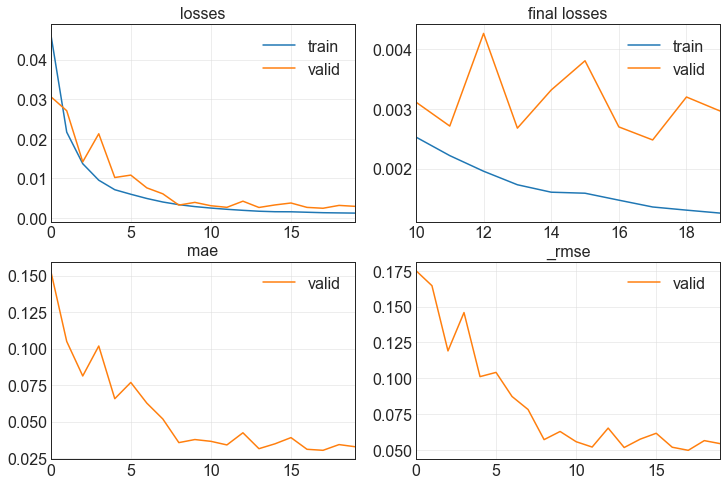

7.734908819198608                                                                                                      
[0.0012551029212772846, 0.0029621608555316925, 0.03287653625011444, 0.054425742477178574]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}     
ResNet                                                                                                                 
 88%|███████████████████████████████████████▌     | 44/50 [18:11<01:52, 18.76s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.137161,0.114012,0.309827,0.337657,00:00
1,0.125964,0.104882,0.294317,0.323855,00:00
2,0.109473,0.092307,0.272189,0.303820,00:00
3,0.089194,0.078035,0.251213,0.279347,00:00
4,0.068745,0.055631,0.214704,0.235863,00:00
5,0.051304,0.032695,0.165853,0.180817,00:00
6,0.037800,0.020274,0.129764,0.142385,00:00
7,0.027881,0.014603,0.108339,0.120842,00:00
8,0.020599,0.010426,0.089516,0.102109,00:00
9,0.015342,0.008222,0.078300,0.090673,00:00


No improvement since epoch 26: early stopping                                                                          
 88%|███████████████████████████████████████▌     | 44/50 [18:23<01:52, 18.76s/trial, best loss: 0.0024380148388445377]

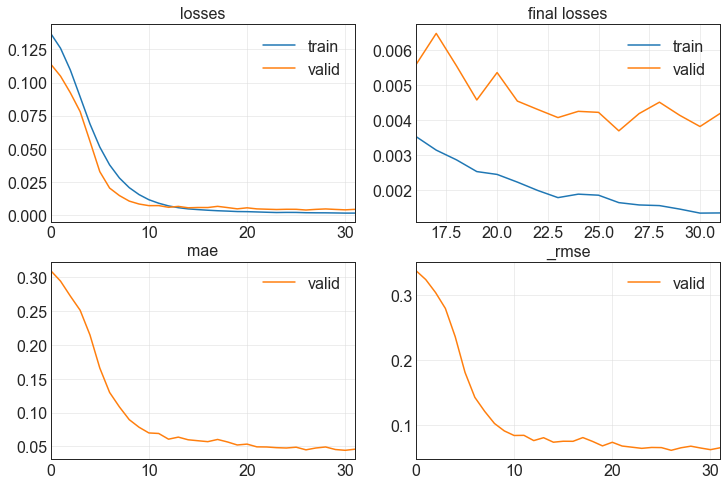

12.186256408691406                                                                                                     
[0.001360297086648643, 0.004192014690488577, 0.04586653411388397, 0.06474576890468597]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 90%|████████████████████████████████████████▌    | 45/50 [18:23<01:24, 16.95s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.027618,0.038479,0.163303,0.196160,00:00
1,0.013710,0.007147,0.055520,0.084540,00:00
2,0.008856,0.006083,0.054286,0.077995,00:00
3,0.006287,0.006727,0.054113,0.082017,00:00
4,0.004673,0.005110,0.049222,0.071486,00:00
5,0.003996,0.005831,0.051121,0.076364,00:00
6,0.003257,0.002879,0.036360,0.053657,00:00
7,0.002741,0.002704,0.032658,0.052004,00:00
8,0.002505,0.006640,0.052855,0.081487,00:00
9,0.002406,0.005086,0.048534,0.071315,00:00


No improvement since epoch 7: early stopping                                                                           
 90%|████████████████████████████████████████▌    | 45/50 [18:30<01:24, 16.95s/trial, best loss: 0.0024380148388445377]

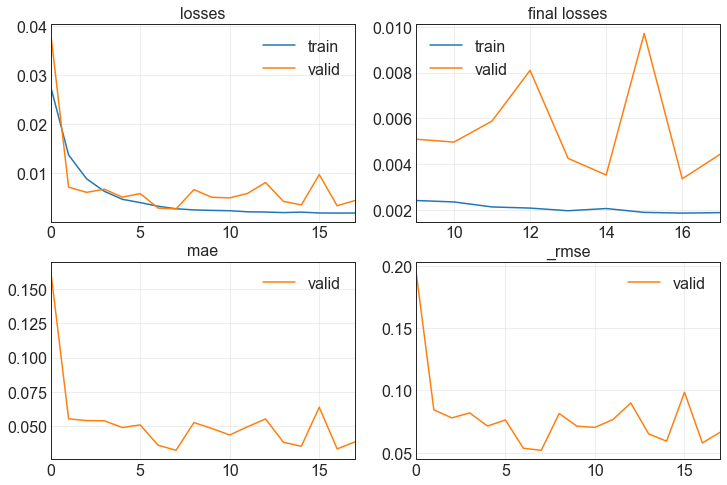

7.014523267745972                                                                                                      
[0.001876772497780621, 0.0044332873076200485, 0.03886028751730919, 0.06658293306827545]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}       
ResNet                                                                                                                 
 92%|█████████████████████████████████████████▍   | 46/50 [18:31<00:56, 14.13s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.023127,0.035761,0.131943,0.189105,00:00
1,0.011976,0.019861,0.098599,0.140928,00:00
2,0.007872,0.006787,0.050128,0.082384,00:00
3,0.005705,0.004742,0.043427,0.068862,00:00
4,0.004350,0.006355,0.048208,0.079715,00:00
5,0.003396,0.004372,0.041511,0.066121,00:00
6,0.002839,0.003304,0.039601,0.057477,00:00
7,0.002435,0.002962,0.035654,0.054424,00:00
8,0.002304,0.004560,0.040209,0.067531,00:00
9,0.002321,0.002754,0.033189,0.052480,00:00


No improvement since epoch 13: early stopping                                                                          
 92%|█████████████████████████████████████████▍   | 46/50 [18:38<00:56, 14.13s/trial, best loss: 0.0024380148388445377]

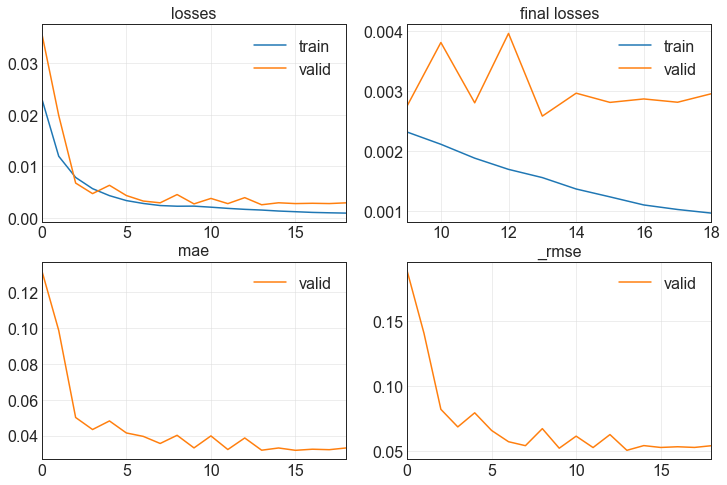

7.3989880084991455                                                                                                     
[0.0009700747323222458, 0.002959880046546459, 0.03316543623805046, 0.05440477654337883]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}     
ResNet                                                                                                                 
 94%|██████████████████████████████████████████▎  | 47/50 [18:39<00:36, 12.27s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.102637,0.111624,0.304291,0.334102,00:00
1,0.064795,0.057816,0.211403,0.240449,00:00
2,0.041124,0.033339,0.166812,0.182589,00:00
3,0.026474,0.010173,0.080746,0.100862,00:00
4,0.017439,0.006325,0.059166,0.079530,00:00
5,0.011903,0.007811,0.065613,0.088377,00:00
6,0.008497,0.004007,0.048326,0.063302,00:00
7,0.006336,0.005145,0.050640,0.071726,00:00
8,0.005021,0.006201,0.057852,0.078744,00:00
9,0.004000,0.005537,0.051706,0.074408,00:00


No improvement since epoch 17: early stopping                                                                          
 94%|██████████████████████████████████████████▎  | 47/50 [18:49<00:36, 12.27s/trial, best loss: 0.0024380148388445377]

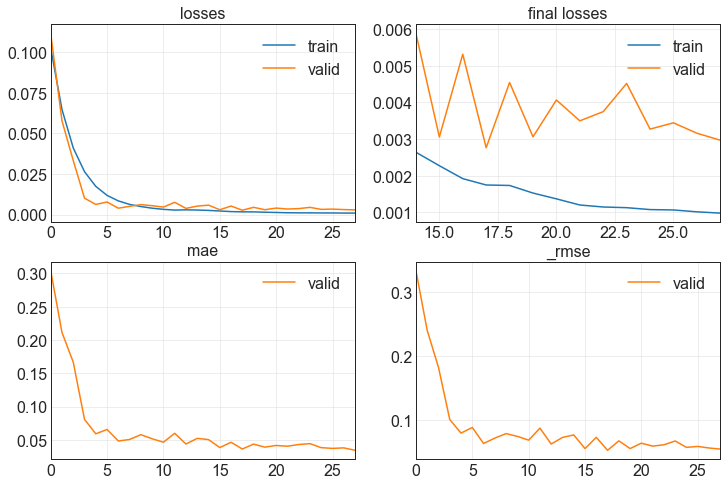

10.745053052902222                                                                                                     
[0.0009799274848774076, 0.0029699746519327164, 0.03435078263282776, 0.05449747294187546]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}        
ResNet                                                                                                                 
 96%|███████████████████████████████████████████▏ | 48/50 [18:50<00:23, 11.97s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.010694,0.012084,0.088144,0.109927,00:01
1,0.005916,0.020007,0.115734,0.141446,00:01
2,0.005102,0.005084,0.042965,0.071300,00:01
3,0.004257,0.008809,0.055561,0.093855,00:01
4,0.003494,0.005319,0.045514,0.072928,00:01
5,0.002890,0.005625,0.046210,0.074998,00:01
6,0.002493,0.005947,0.050056,0.077114,00:01
7,0.002137,0.003967,0.037333,0.062982,00:01
8,0.002049,0.003362,0.038732,0.057986,00:01
9,0.002020,0.004804,0.042587,0.069309,00:01


No improvement since epoch 12: early stopping                                                                          
 96%|███████████████████████████████████████████▏ | 48/50 [19:15<00:23, 11.97s/trial, best loss: 0.0024380148388445377]

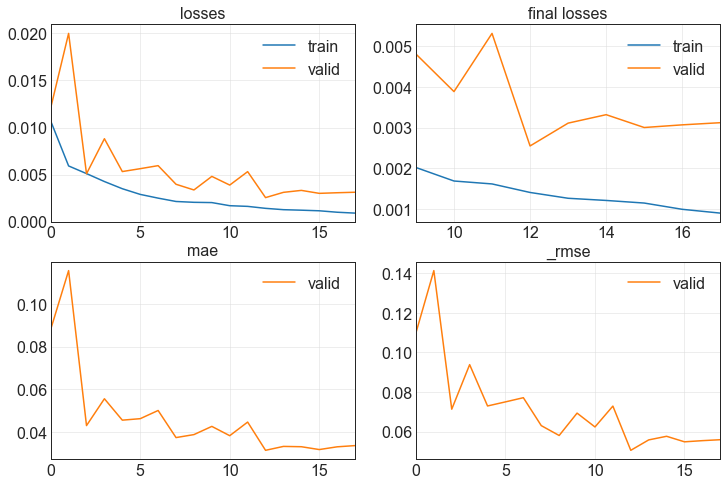

24.720300674438477                                                                                                     
[0.0009009120403788984, 0.003119356231763959, 0.0335673950612545, 0.05585119128227234]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 10}    
ResNet                                                                                                                 
 98%|████████████████████████████████████████████ | 49/50 [19:16<00:15, 15.96s/trial, best loss: 0.0024380148388445377]

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.135334,0.178564,0.377833,0.422568,00:00
1,0.087770,0.094241,0.276448,0.306988,00:00
2,0.058212,0.042532,0.188209,0.206233,00:00
3,0.039428,0.026291,0.147219,0.162144,00:00
4,0.027294,0.017425,0.114738,0.132005,00:00
5,0.019126,0.014122,0.100477,0.118837,00:00
6,0.013558,0.008961,0.075289,0.094665,00:00
7,0.009875,0.007941,0.070328,0.089114,00:00
8,0.007644,0.007354,0.066679,0.085756,00:00
9,0.005777,0.005848,0.055784,0.076471,00:00


No improvement since epoch 26: early stopping                                                                          
 98%|████████████████████████████████████████████ | 49/50 [19:29<00:15, 15.96s/trial, best loss: 0.0024380148388445377]

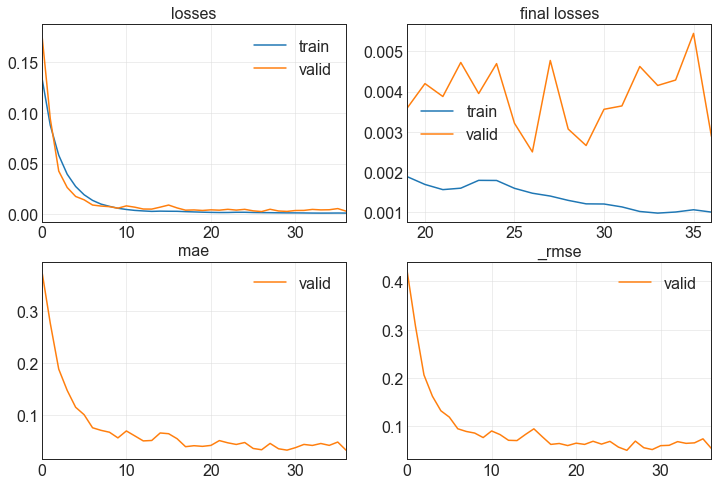

14.018295288085938                                                                                                     
[0.001003957586362958, 0.0028883616905659437, 0.03186371922492981, 0.05374348163604736]                                
100%|█████████████████████████████████████████████| 50/50 [19:30<00:00, 23.40s/trial, best loss: 0.0024380148388445377]


In [59]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [60]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'optimizer': <function Adam at 0x0000023DE30D5048>, 'patience': 5}


In [61]:
# only for debug
# params = {'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'lr': 0.01, 'layers': [500, 500, 500], 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [62]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [63]:
batch_size = params["batch_size"]
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [64]:
arch = ResNet
model = create_model(arch, dls=dls)
print(model.__class__.__name__)

# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())
model

ResNet


Sequential(
  (0): ResNet(
    (resblock1): ResBlock(
      (convblock1): ConvBlock(
        (0): Conv1d(3, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (convblock2): ConvBlock(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (convblock3): ConvBlock(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): ConvBlock(
        (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (add): Add
      (act): ReLU()
    )
    (resblock

Training the model:

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.026072,0.030316,0.125735,0.174116,00:00
1,0.013158,0.010445,0.063458,0.102200,00:00
2,0.008585,0.011199,0.067774,0.105827,00:00
3,0.005991,0.005687,0.056702,0.075411,00:00
4,0.004506,0.007047,0.053498,0.083946,00:00
5,0.003576,0.005001,0.040493,0.070717,00:00
6,0.003113,0.007772,0.055060,0.088157,00:00
7,0.002700,0.005828,0.052051,0.076339,00:00
8,0.002353,0.002472,0.034527,0.049718,00:00
9,0.002300,0.004438,0.040256,0.066616,00:00


No improvement since epoch 14: early stopping


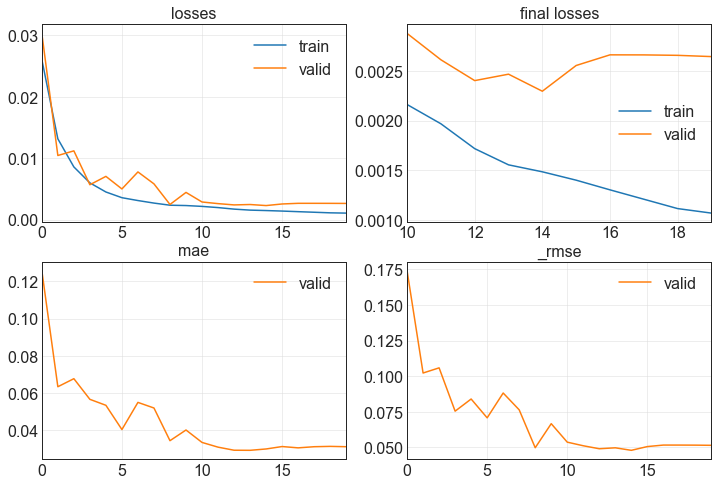

In [65]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [66]:
dls = learn.dls
valid_dl = dls.valid

test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

708


In [67]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0166],
         [0.0423],
         [0.0118],
         [0.0101],
         [0.0083],
         [0.0072],
         [0.0079],
         [0.0062],
         [0.0082],
         [0.0211],
         [0.1519],
         [0.0378],
         [0.0295],
         [0.0302],
         [0.0244],
         [0.0138],
         [0.0165],
         [0.0176],
         [0.0129],
         [0.0145],
         [0.0207],
         [0.0349],
         [0.0200],
         [0.0127],
         [0.0154],
         [0.0154],
         [0.0159],
         [0.0136],
         [0.0143],
         [0.0114],
         [0.0154],
         [0.0124],
         [0.0125],
         [0.0500],
         [0.3442],
         [0.6539],
         [0.6416],
         [0.6324],
         [0.6319],
         [0.5818],
         [0.7014],
         [0.6146],
         [0.5379],
         [0.3839],
         [0.2864],
         [0.1674],
         [0.0932],
         [0.0597],
         [0.0295],
         [0.0184],
         [0.0177],
         [0.0318],
         [0.

In [68]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [69]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

Transform the data in the normal range:

In [70]:
def inverse_normalization(prediction, y, max_list, min_list):
    # we only use the max and min for value_avg
    max_value = max_list[0]
    min_value = min_list[0]
    inverse_prediction = prediction * (max_value - min_value) + min_value
    inverse_y = y * (max_value - min_value) + min_value

    return inverse_prediction, inverse_y

In [71]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, 0], y_true[i, step, 0], max_list, min_list)
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [72]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [73]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [74]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  7.357062816619873
Test time (in seconds):  0.0839993953704834


In [23]:
print('Training time (in seconds): ', 7.357062816619873 / 20)

Training time (in seconds):  0.36785314083099363


Define the evaluation metrics:

In [75]:
def check_error(orig, pred, name_col='', index_name=''):
    
    bias = np.mean(orig - pred)
    mse = mean_squared_error(orig, pred)
    rmse = sqrt(mean_squared_error(orig, pred))
    mae = mean_absolute_error(orig, pred)
    mape = np.mean(np.abs((orig - pred) / orig)) * 100
    
    error_group = [bias, mse, rmse, mae, mape]
    result = pd.DataFrame(error_group, index=['BIAS','MSE','RMSE','MAE', 'MAPE'], columns=[name_col])
    result.index.name = index_name
    
    return result

We evaluate the prediction in the next step:

In [76]:
step_to_evalute = 0
true_values = y_true[:, step_to_evalute]
pred_values = y_pred[:, step_to_evalute]

In [77]:
result = pd.DataFrame()

In [78]:
check_error(true_values, pred_values, name_col=model_name)

,ResNet
,
BIAS,-4.917280e+05
MSE,1.363635e+14
RMSE,1.167748e+07
MAE,7.158389e+06
MAPE,5.603583e+01


We would also analyze the characteristics of the residual itself, as there are cases where the model can not capture the information necessary to make a good forecast resulting in a error with information that should be used to improve the forecast.

To verify this residual we will check:

* Actual vs. predicted values (sequential chart);

* Residual vs. predicted values (dispersion chart):
    + It is very important to analyze this graph, since in it we can check patterns that can tell us if some modification is needed in the model, the ideal is that the error is distributed linearly along the forecast sequence.

* QQ plot of the residual (dispersion chart):
    + Summarizing this is a graph that shows where the residue should be theoretically distributed, following a Gaussian distribution, versus how it actually is.

* Residual autocorrelation (sequential chart):
    + Where there should be no values that come out of the confidence margin, or the model is leaving information out of the model.

In [79]:
def plot_error(data, figsize=(12, 9), lags=24, rotation=0):
    
    # Creating the column error
    data['Error'] = data.iloc[:,0] - data.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    # Plotting actual and predicted values
    ax1.plot(data.iloc[:, 0:2])
    ax1.legend(['Real', 'Pred'])
    ax1.set_title('Real Value vs Prediction')
    ax1.xaxis.set_tick_params(rotation=rotation)
    
    # Error vs Predicted value
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residual')
    ax2.set_title('Residual vs Predicted Values')
    
    # Residual QQ Plot
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation Plot of residual
    plot_acf(data.iloc[:, 2], lags=lags, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

Now we evaluate on the test set:

In [80]:
target = 'value_avg'

model_test = test[[target]].copy()
model_test.index = test.index
model_test.columns = ['Real']

model_test['Pred'] = pred_values

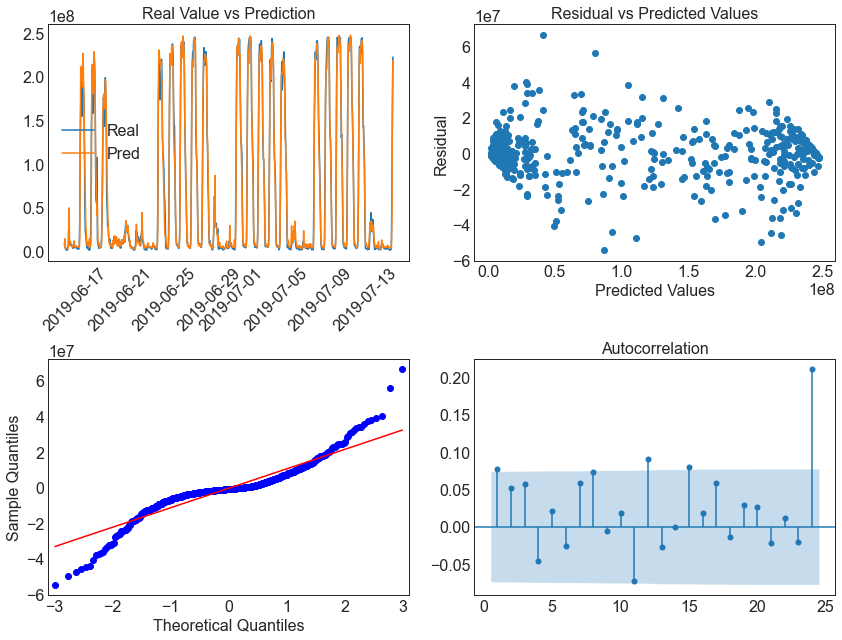

In [81]:
plot_error(model_test, rotation=45)